[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ryanharvey1/neuro_py/blob/main/tutorials/spatial_map.ipynb)
&nbsp;
[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ryanharvey1/neuro_py/main/tutorials/spatial_map.ipynb)
&nbsp;
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/ryanharvey1/neuro_py/main?labpath=tutorials%2Fspatial_map.ipynb)

# Spatial Map

This short notebook will guide you over loading data and using
[`SpatialMap`](https://ryanharvey1.github.io/neuro_py/reference/neuro_py/tuning/maps/#neuro_py.tuning.maps.SpatialMap)
class.

We first go over 2D maps and then have 1D maps, and finally mapping continuous
variables.

---

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import nelpy as nel
import nelpy.plotting as npl
import numpy as np
import seaborn as sns
from skimage import measure

import neuro_py as npy
from neuro_py.behavior.linear_positions import get_linear_track_lap_epochs
from neuro_py.ensemble.assembly_reactivation import AssemblyReact
from neuro_py.io import loading
from neuro_py.plotting.figure_helpers import set_size
from neuro_py.tuning import maps

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import logging

logging.getLogger().setLevel(logging.ERROR)

## Section 1: Specify basepath to your session of interest

In [2]:
basepath = r"Z:\Data\Kenji\ec013.961_974"

## Section 2: load in behavior and spike data

In [3]:
# load position
position_df = loading.load_animal_behavior(basepath)

# put position into a nelpy position array for ease of use
pos = nel.AnalogSignalArray(
    data=position_df[["x", "y"]].values.T,
    timestamps=position_df.timestamps.values,
)
# calculate speed
speed = nel.utils.ddt_asa(pos, smooth=True, sigma=0.250, norm=True)

# load in spike data from hpc pyramidal cells
st, cm = loading.load_spikes(
    basepath, putativeCellType="Pyr", brainRegion="CA1|CA2|CA3"
)

## Section 3: Load in epochs and make a note of which session you want to analyze

Here, I'm first interested in the last *bigSquare* session

In [4]:
epoch_df = loading.load_epoch(basepath)
beh_epochs = nel.EpochArray(np.array([epoch_df.startTime, epoch_df.stopTime]).T)

# you can change this based on which session you want to look at
behavior_idx = 11

# print out data frame
epoch_df

name   startTime    stopTime environment  \
0       ec013.961_sleep      0.0000    321.9456       sleep   
1       ec013.962_sleep    321.9456   2475.2456       sleep   
2       ec013.963_sleep   2475.2456   5748.3596       sleep   
3       ec013.964_sleep   5748.3596   6035.4892       sleep   
4      ec013.965_linear   6035.4892   7481.7872      linear   
5      ec013.966_linear   7481.7872   9050.3872      linear   
6       ec013.967_sleep   9050.3872  10959.9422       sleep   
7       ec013.968_sleep  10959.9422  13312.2752       sleep   
8      ec013.969_linear  13312.2752  15073.9652      linear   
9   ec013.970_bigSquare  15073.9652  17064.4652   bigSquare   
10  ec013.971_bigSquare  17064.4652  18704.5652   bigSquare   
11  ec013.972_bigSquare  18704.5652  21714.0652   bigSquare   
12      ec013.973_wheel  21714.0652  23200.5032       wheel   
13      ec013.974_wheel  23200.5032  24717.6612       wheel   

    behavioralParadigm  manipulation  stimuli  notes  \
0                   10           NaN      NaN    NaN   
1                   10           NaN      NaN    NaN   
2                   10           NaN      NaN    NaN   
3                   10           NaN      NaN    NaN   
4                   10           NaN      NaN    NaN   
5                   10           NaN      NaN    NaN   
6                   10           NaN      NaN    NaN   
7                   10           NaN      NaN    NaN   
8                   10           NaN      NaN    NaN   
9                   10           NaN      NaN    NaN   
10                  10           NaN      NaN    NaN   
11                  10           NaN      NaN    NaN   
12                  10           NaN      NaN    NaN   
13                  10           NaN      NaN    NaN   

                       basepath  
0   Z:\Data\Kenji\ec013.961_974  
1   Z:\Data\Kenji\ec013.961_974  
2   Z:\Data\Kenji\ec013.961_974  
3   Z:\Data\Kenji\ec013.961_974  
4   Z:\Data\Kenji\ec013.961_974  
5   Z:\Data\Kenji\ec013.961_974  
6   Z:\Data\Kenji\ec013.961_974  
7   Z:\Data\Kenji\ec013.961_974  
8   Z:\Data\Kenji\ec013.961_974  
9   Z:\Data\Kenji\ec013.961_974  
10  Z:\Data\Kenji\ec013.961_974  
11  Z:\Data\Kenji\ec013.961_974  
12  Z:\Data\Kenji\ec013.961_974  
13  Z:\Data\Kenji\ec013.961_974

## Section 4: Make tuning curves and detect 2D place fields using the SpatialMap class

You can see I am specifying positions and spikes within our epoch of choice

There are many other parameters you can change, so check out the documentation of the class

In [5]:
spatial_maps = maps.SpatialMap(
    pos[beh_epochs[behavior_idx]],
    st[beh_epochs[behavior_idx]],
    s_binsize=3,
    speed=speed,
    tuning_curve_sigma=3,
    place_field_min_size=15,
    place_field_max_size=1000,
    place_field_sigma=3,
)
spatial_maps.find_fields()

spatial_maps

<TuningCurve2D at 0x1cf61168fd0> with shape (16, 64, 64)

You can also shuffle your data to find which cell has more spatial information
than chance. Depending on how many cells you have this can take a bit of time,
but it shouldn't take more than a minute with the default 500 shuffles.

In [6]:
spatial_info_pvalues = spatial_maps.shuffle_spatial_information()

There are many more class methods available within `spatial_maps.tc`:

In [7]:
[k for k in dir(spatial_maps.tc) if not k.startswith("_")]

['bin_centers',
 'bins',
 'field_mask',
 'field_peak_rate',
 'field_width',
 'information_rate',
 'is2d',
 'isempty',
 'label',
 'mask',
 'max',
 'mean',
 'min',
 'n_bins',
 'n_fields',
 'n_units',
 'n_xbins',
 'n_ybins',
 'normalize',
 'occupancy',
 'ratemap',
 'reorder_units_by_ids',
 'shape',
 'smooth',
 'spatial_information',
 'spatial_selectivity',
 'spatial_sparsity',
 'std',
 'unit_ids',
 'unit_labels',
 'unit_tags',
 'xbin_centers',
 'xbins',
 'ybin_centers',
 'ybins']

## Section 5: Inspect the results by looking at the tuning curves and spikes on path plots

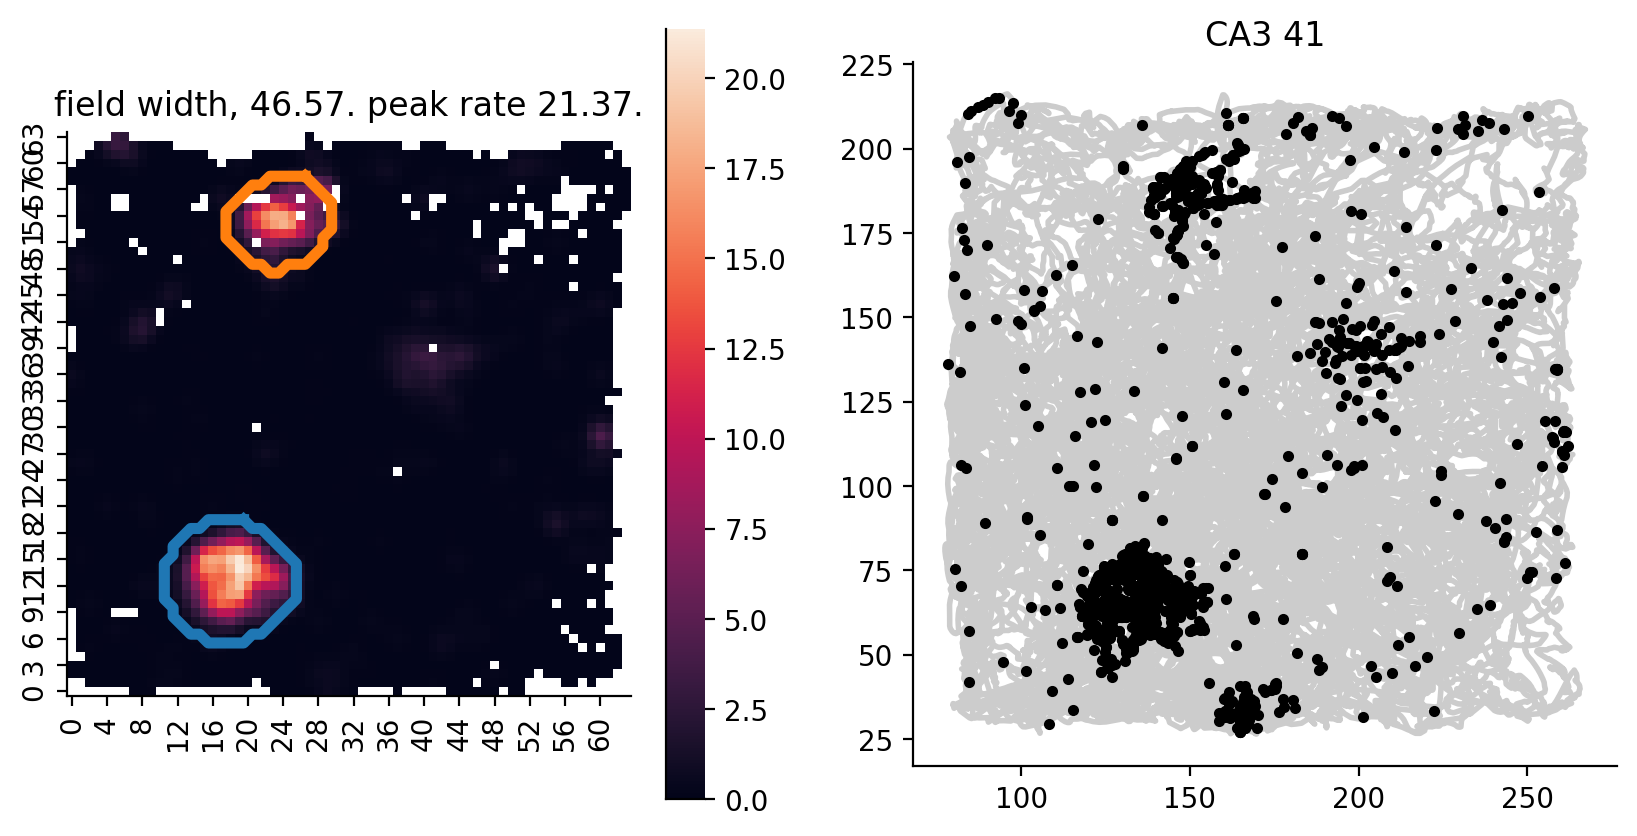

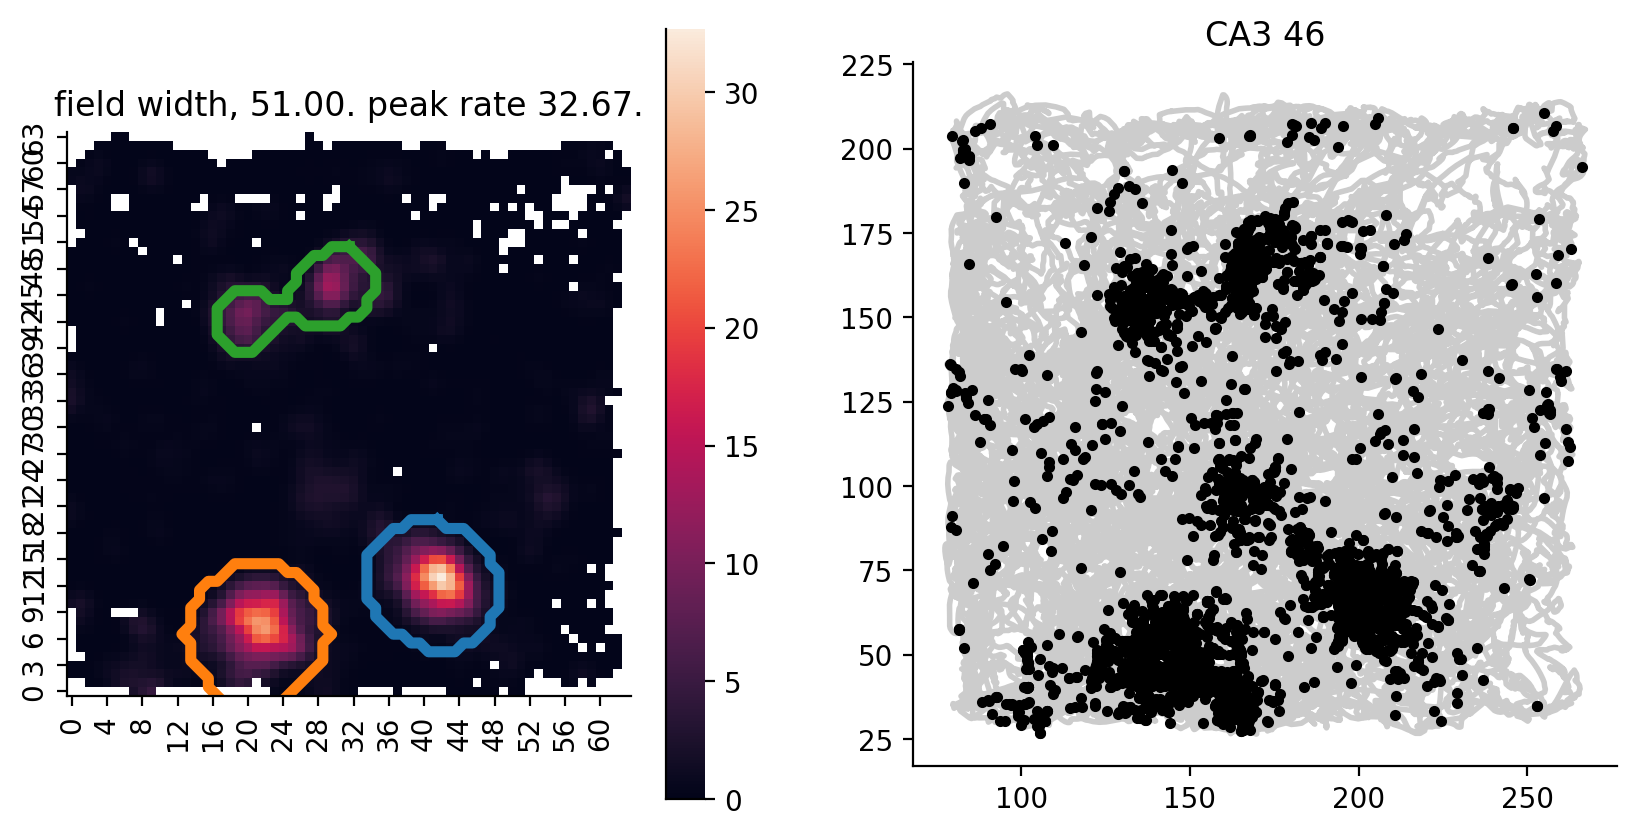

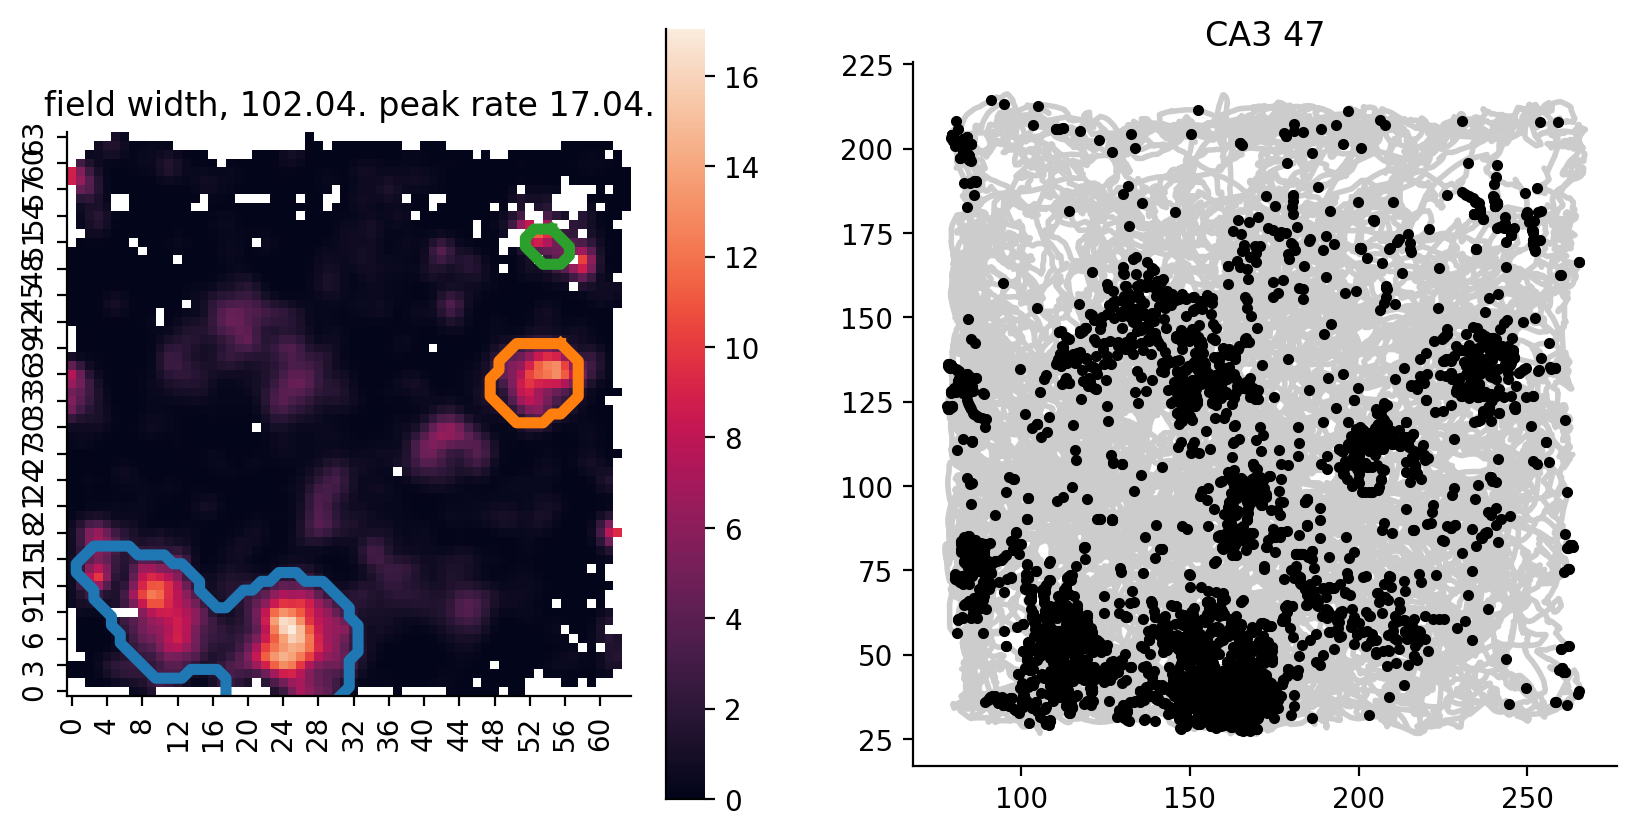

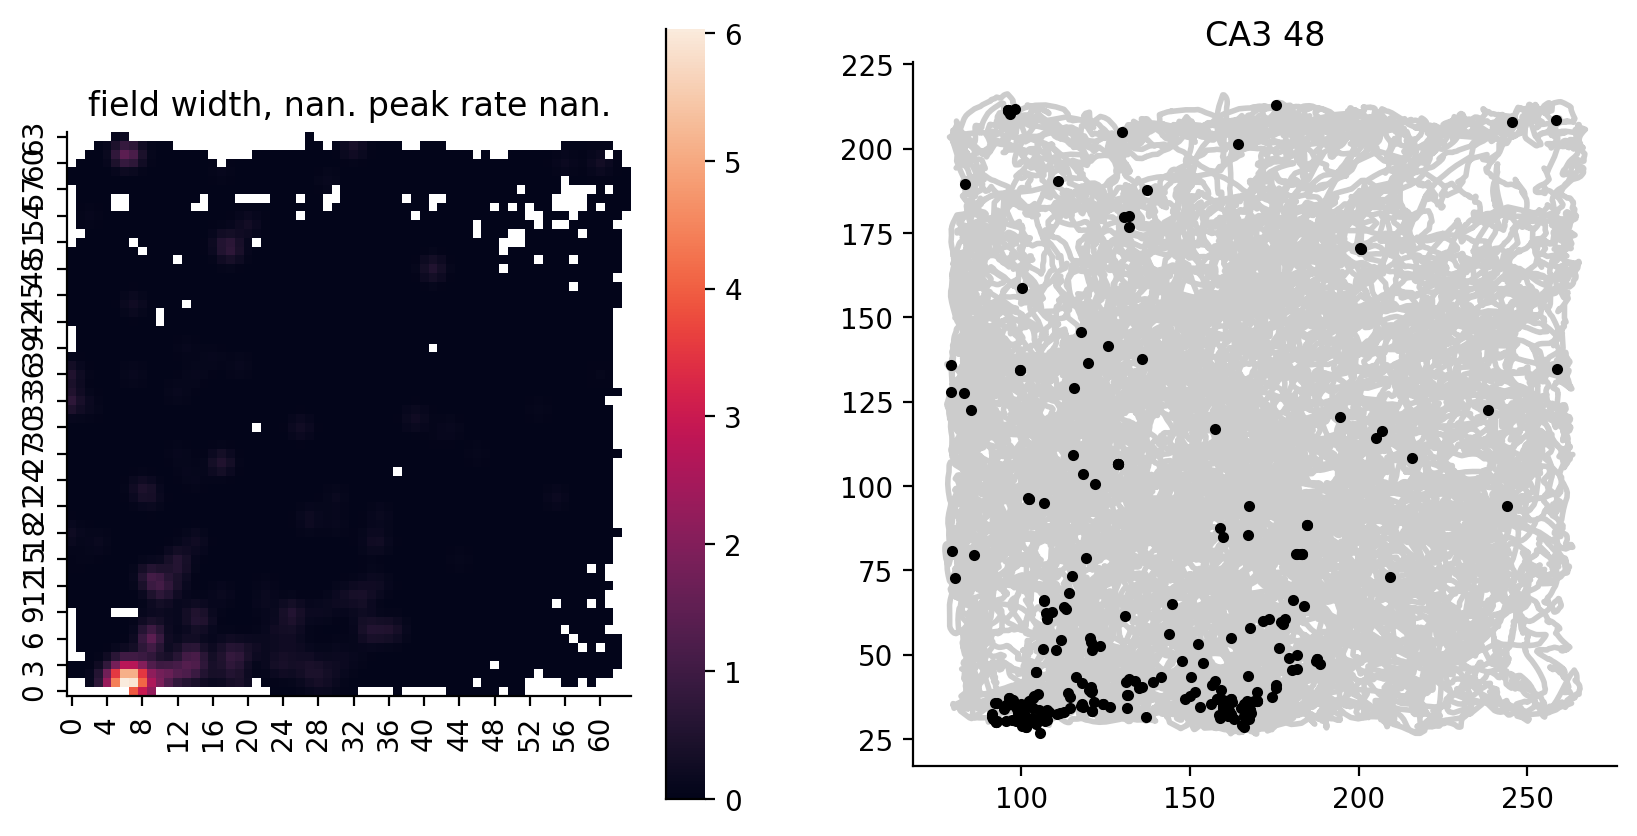

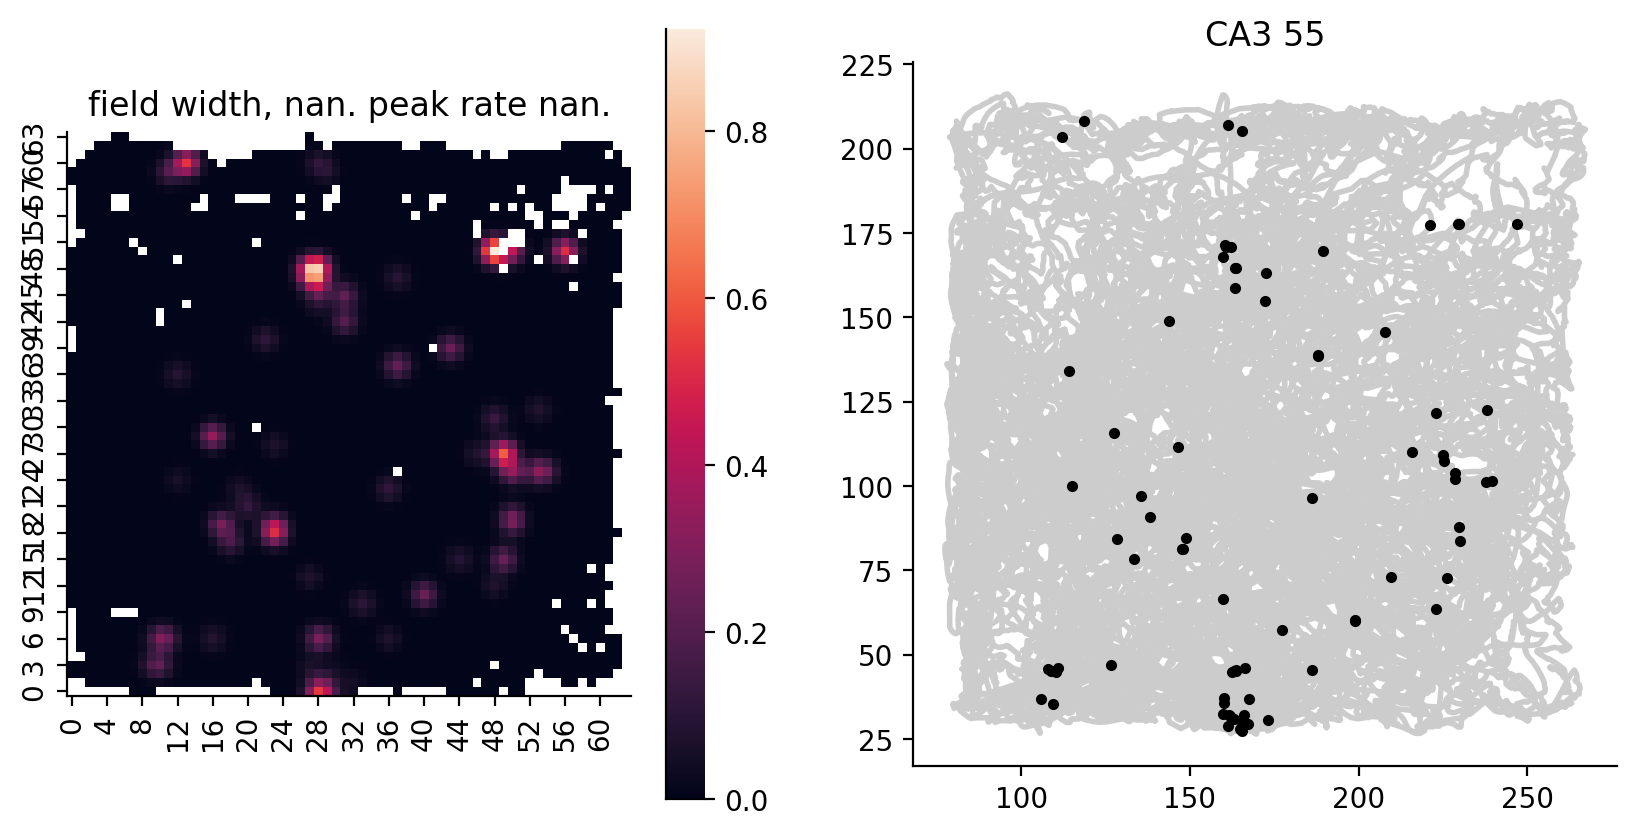

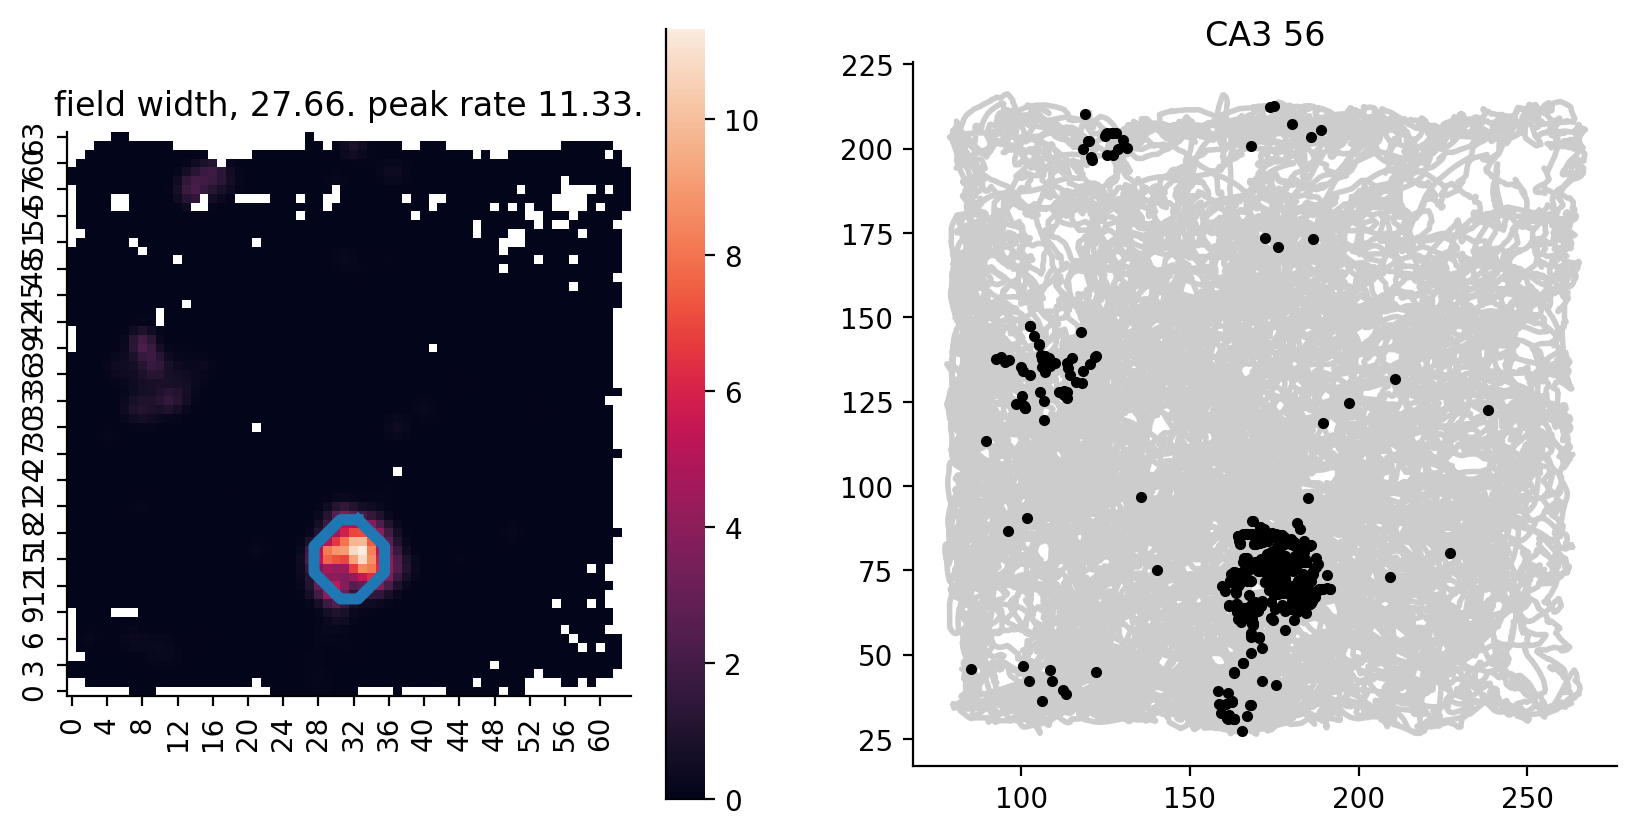

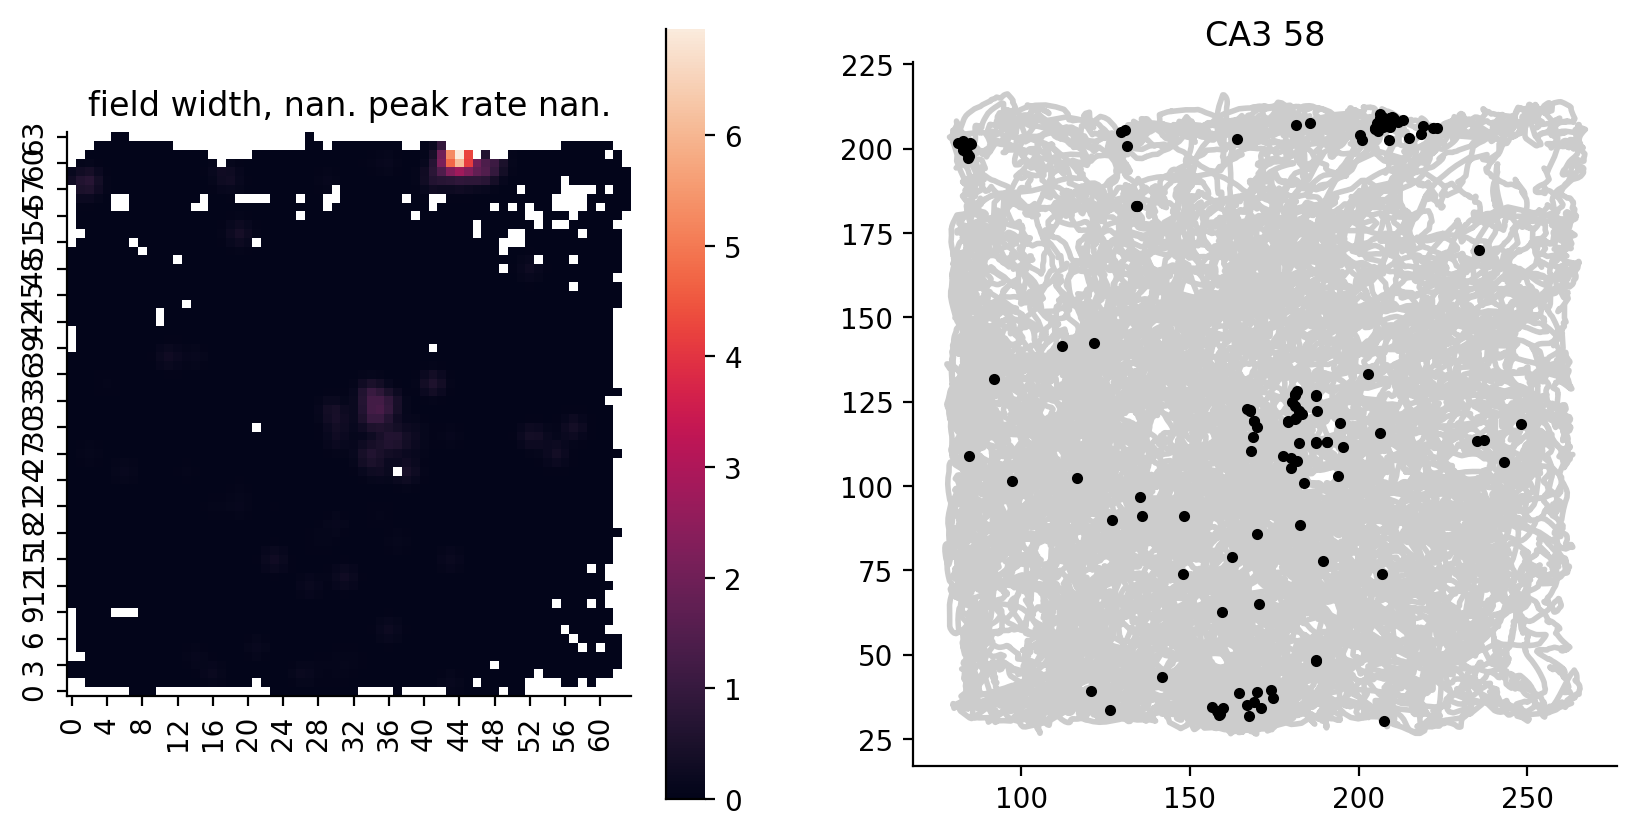

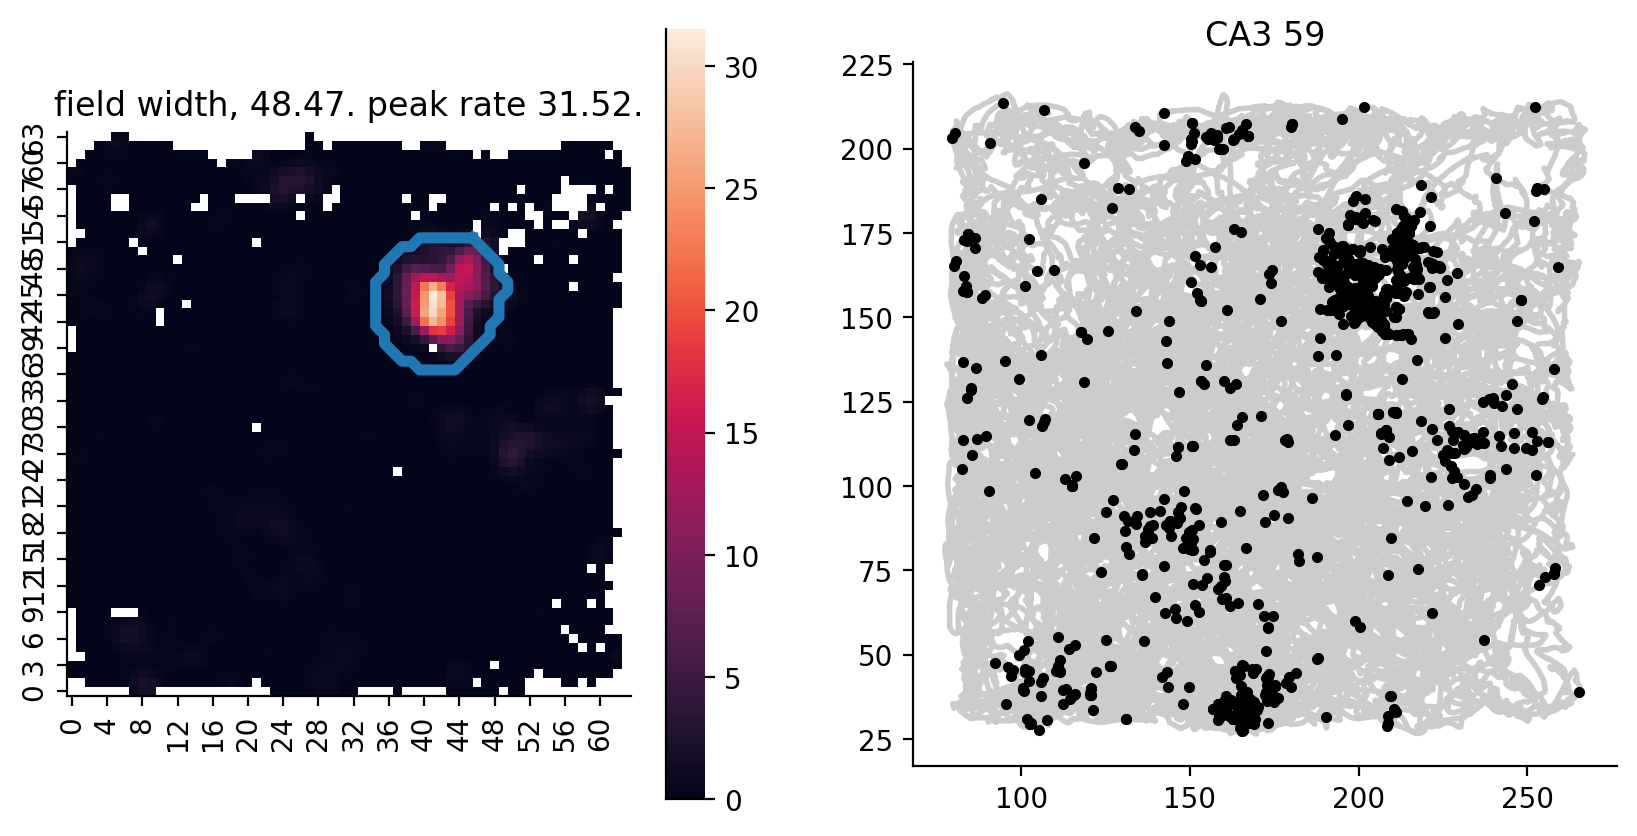

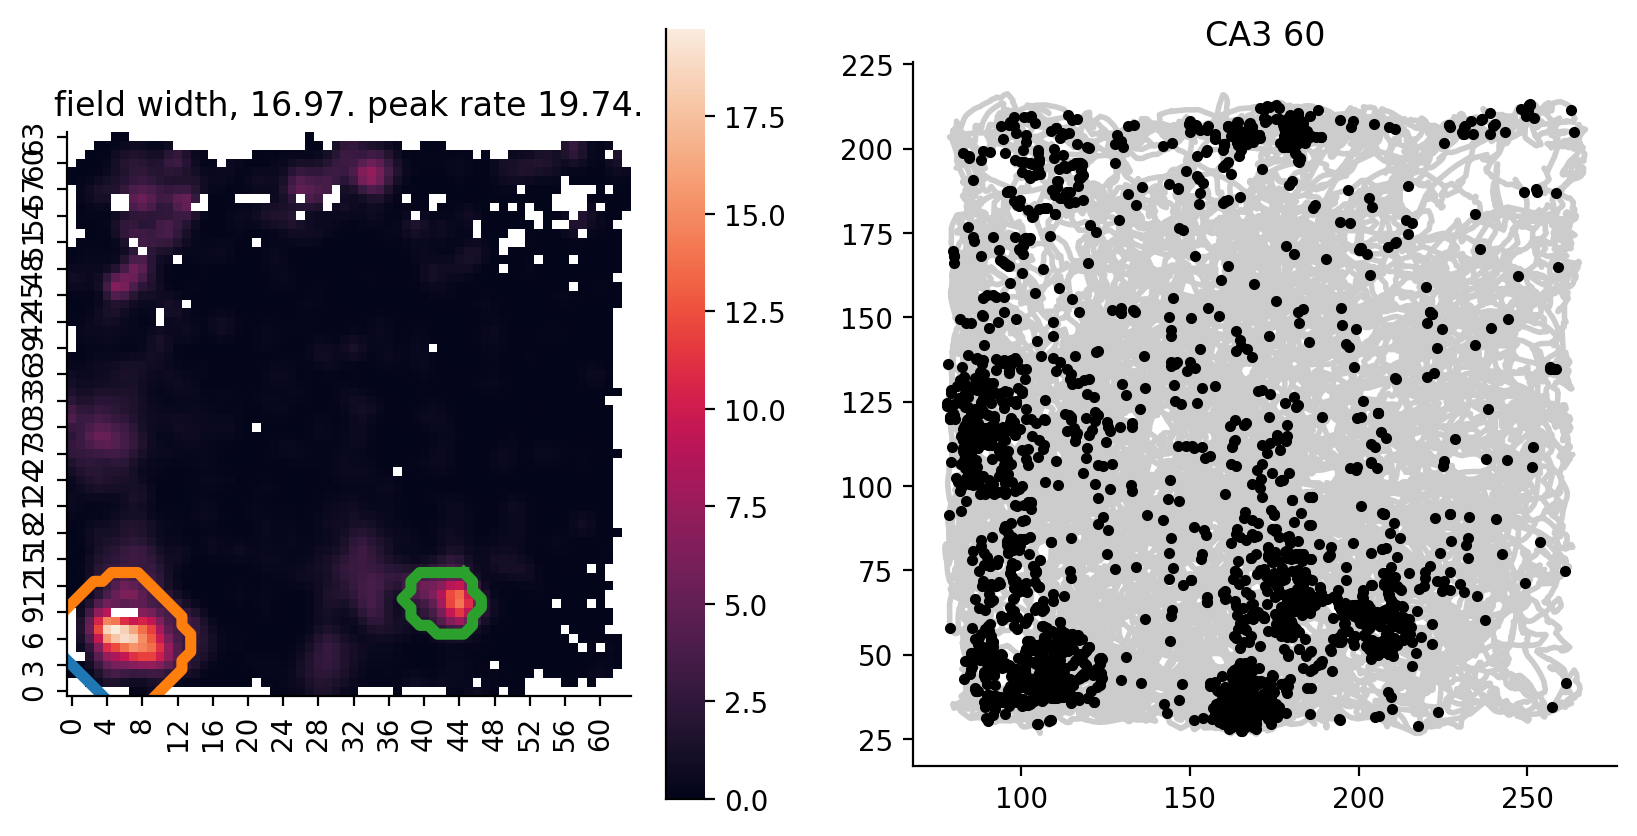

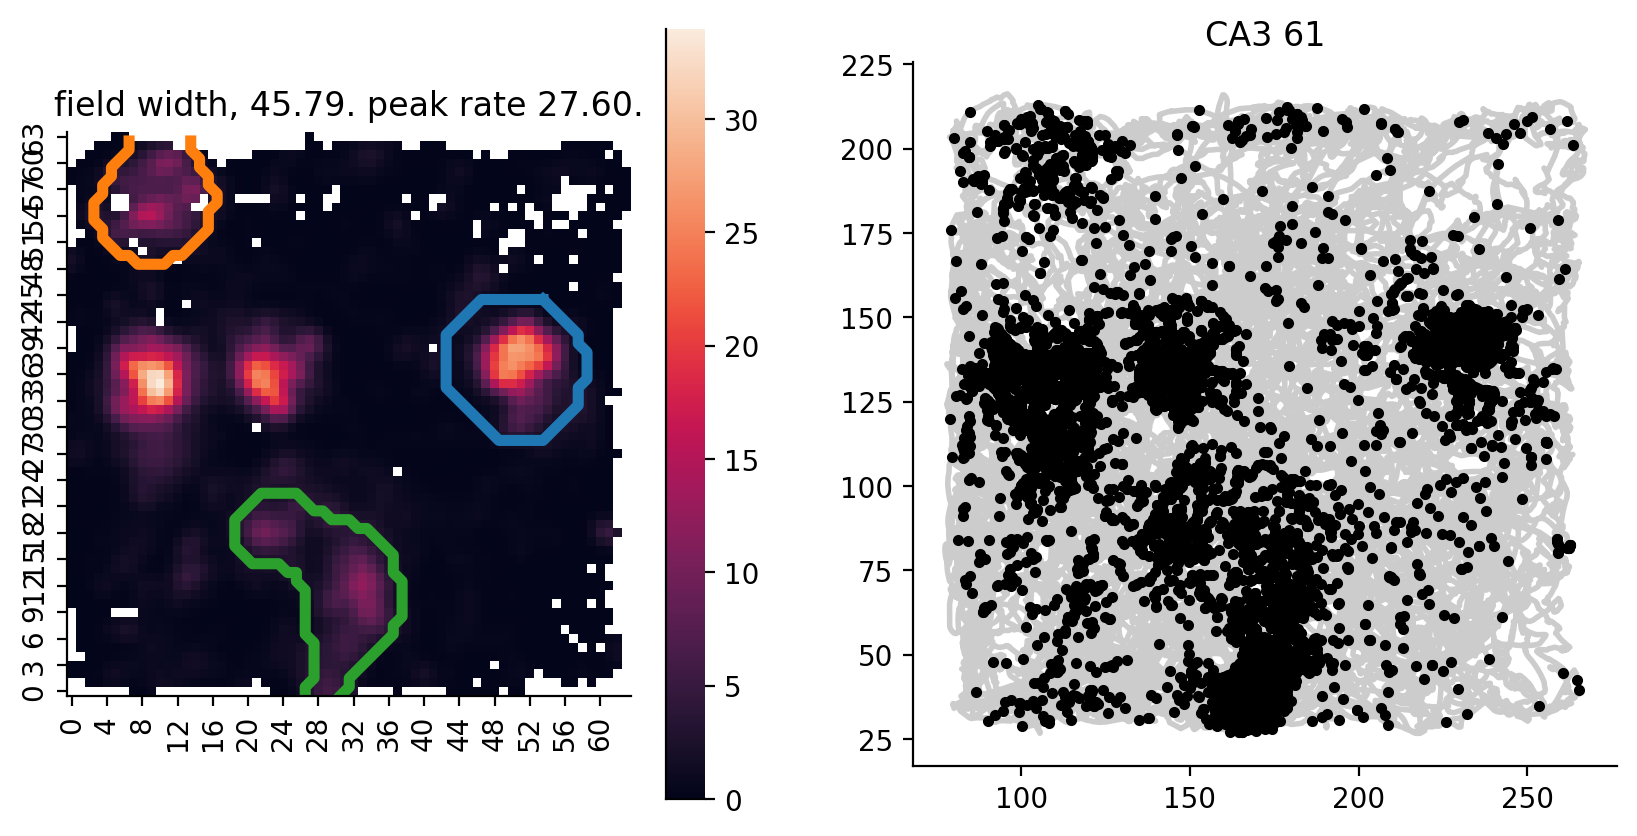

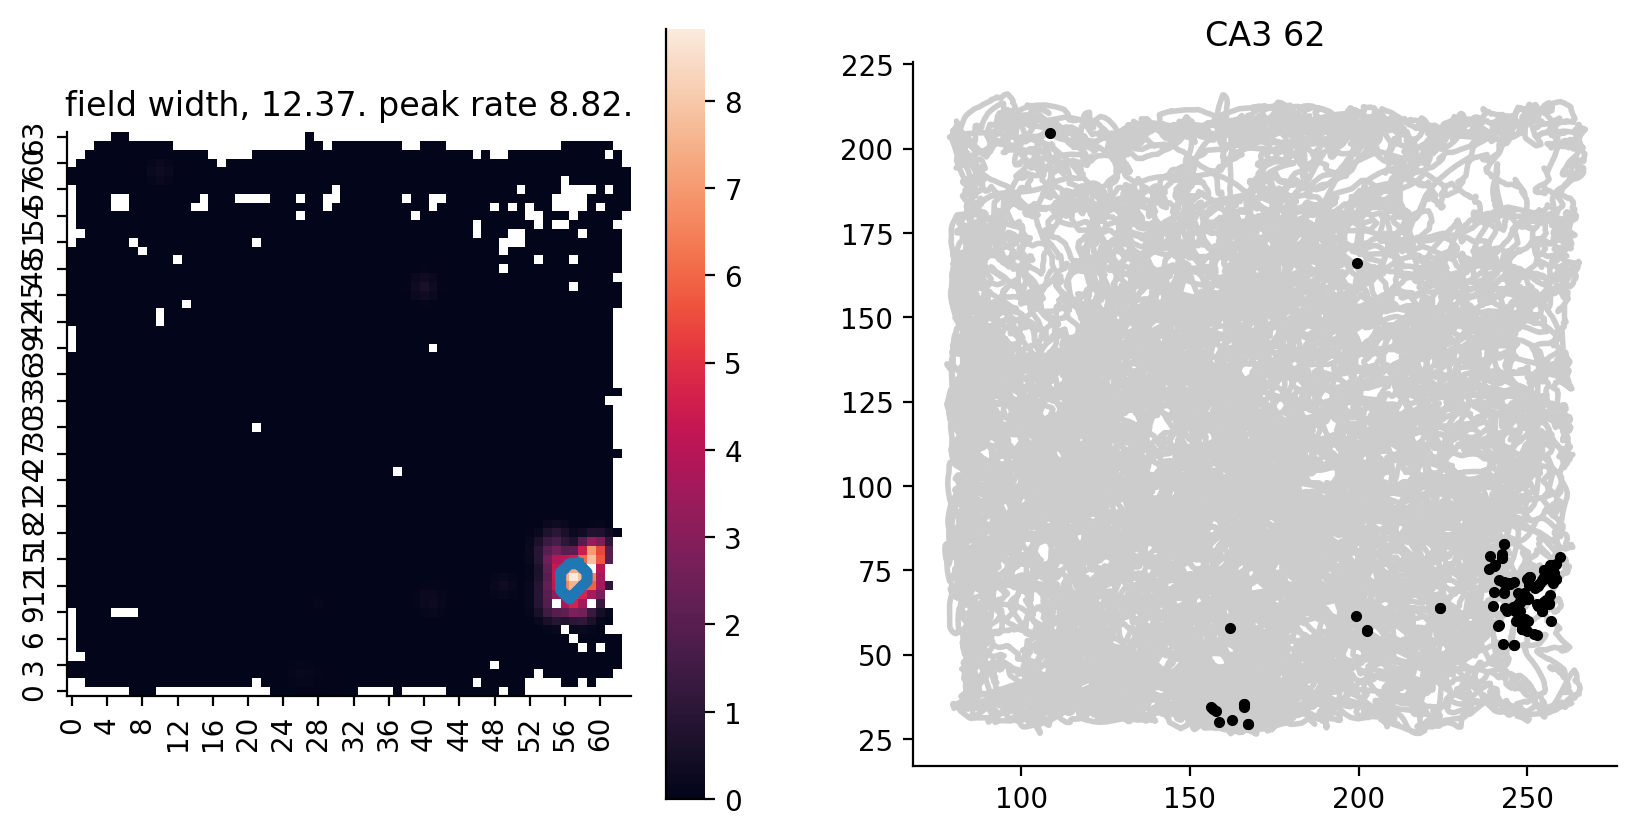

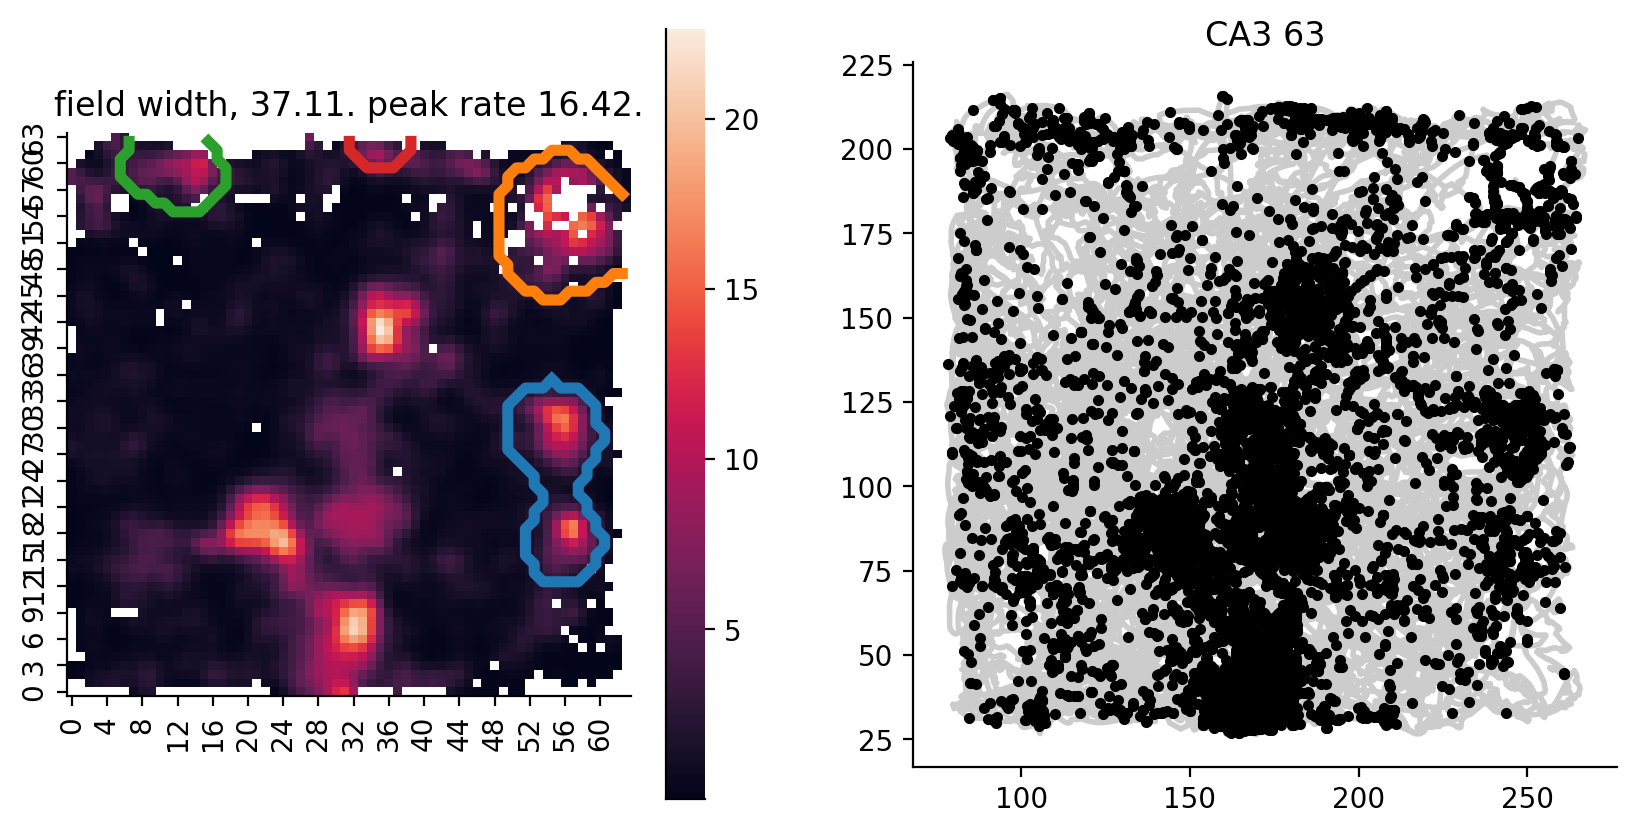

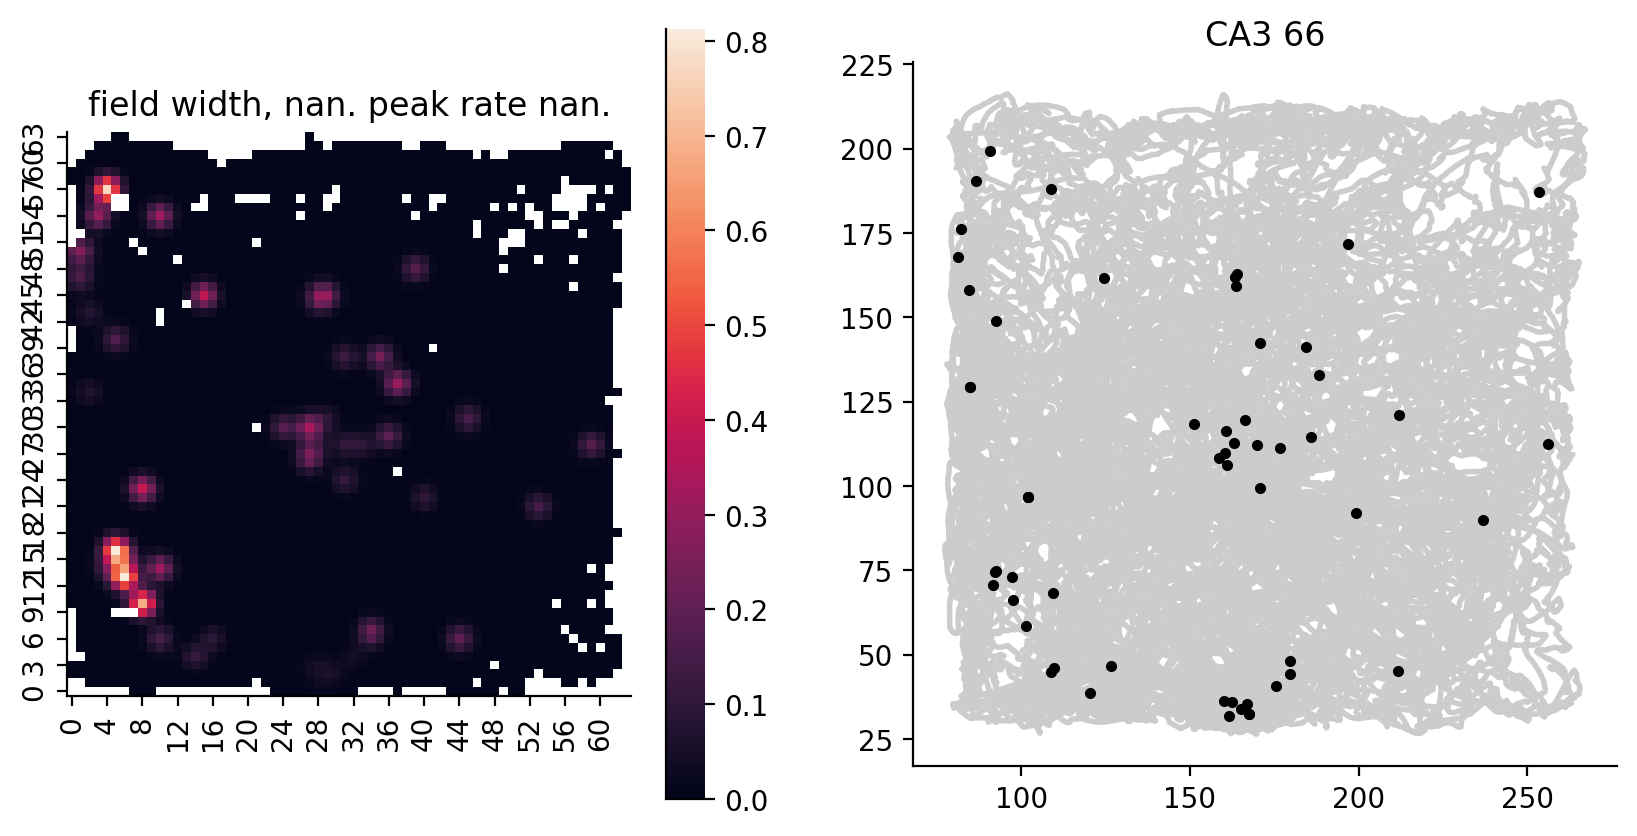

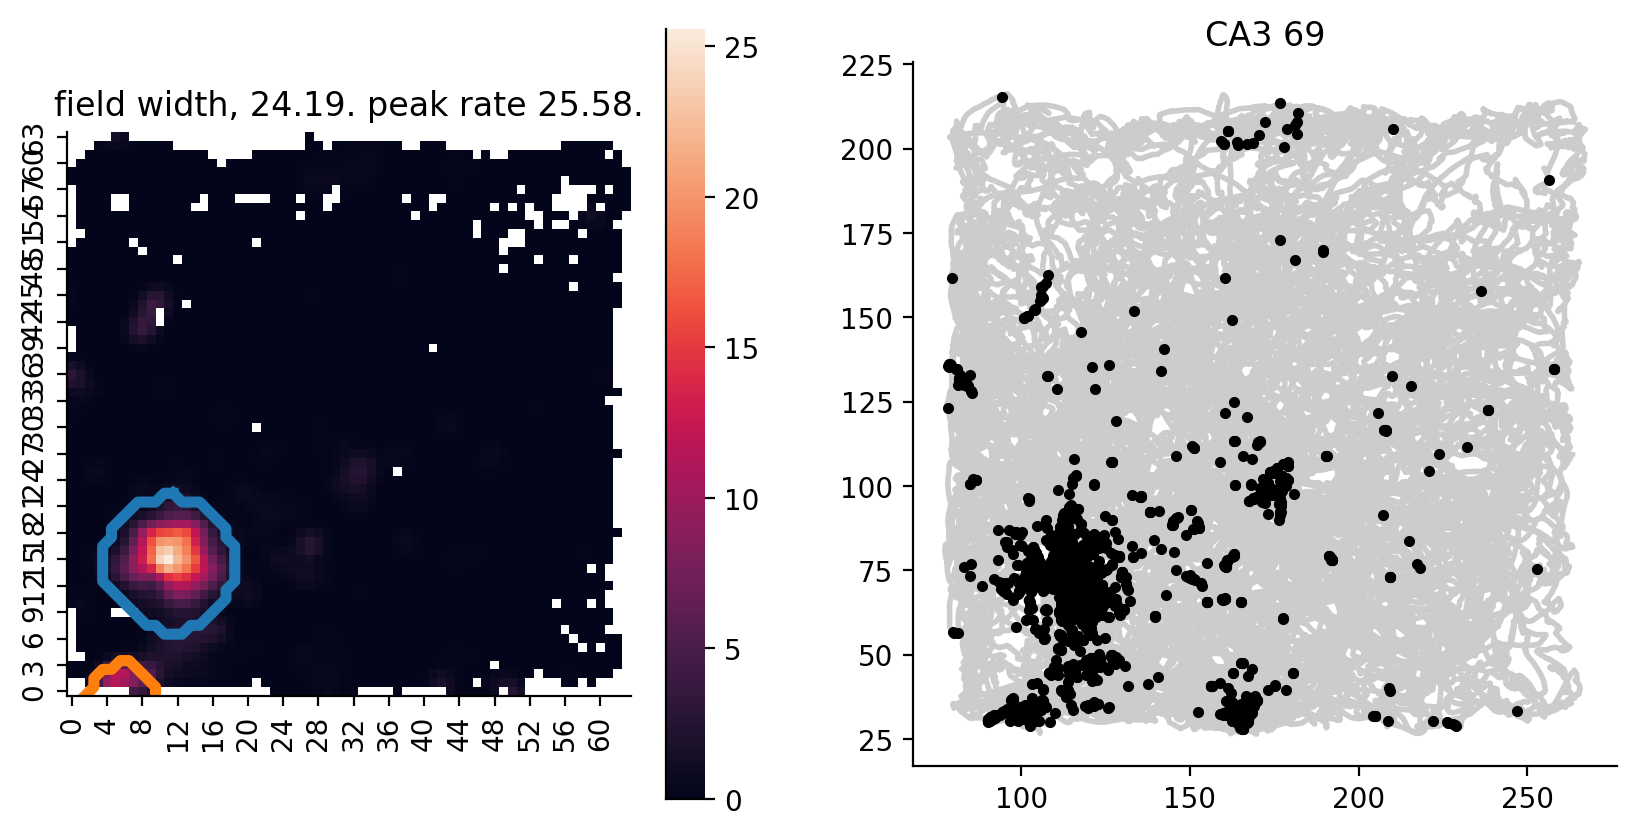

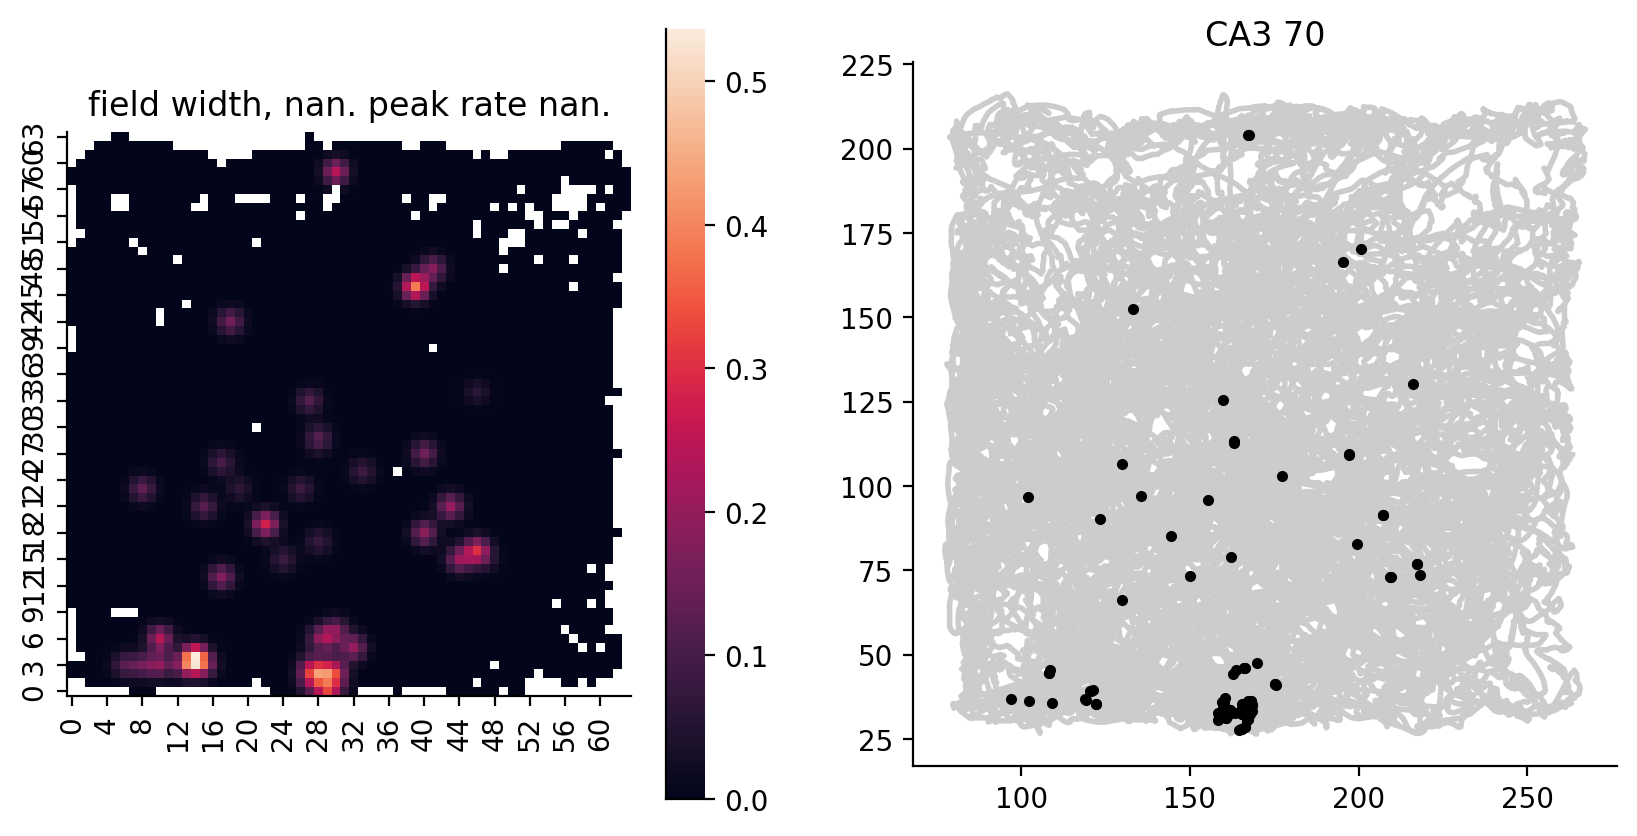

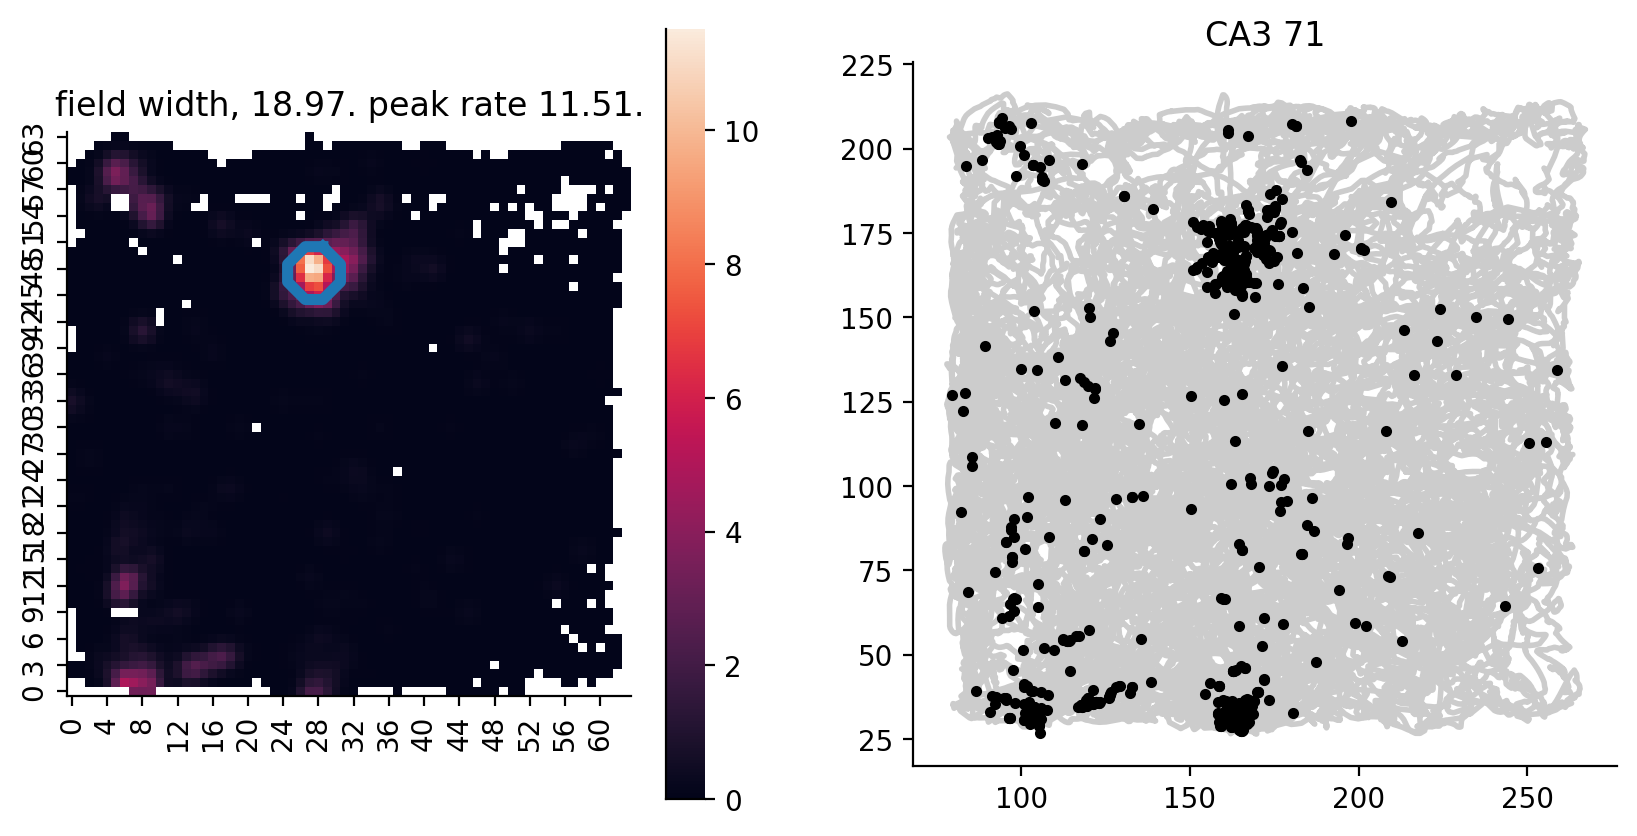

In [8]:
# pull out velocity restricted position
current_pos = pos[beh_epochs[behavior_idx]][spatial_maps.run_epochs]

# iterate over the tuning curves
for ratemap_i, ratemap__ in enumerate(spatial_maps.tc.ratemap):
    ratemap_ = ratemap__.copy()
    ratemap_[spatial_maps.tc.occupancy < 0.01] = np.nan
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    sns.heatmap(ratemap_.T, ax=ax[0])

    field_ids = np.unique(spatial_maps.tc.field_mask[ratemap_i])

    # plot field boundaries over the heat map
    if len(field_ids) > 1:
        for field_i in range(len(field_ids) - 1):
            bc = measure.find_contours(
                (spatial_maps.tc.field_mask[ratemap_i] == field_i + 1).T,
                0,
                fully_connected="low",
                positive_orientation="low",
            )
            for c in bc:
                ax[0].plot(c[:, 1], c[:, 0], linewidth=4)
    ax[0].invert_yaxis()

    # plot xy coords for animal position
    npl.plot2d(current_pos, lw=2, c="0.8", ax=ax[1])

    # plot xy coords for each spike
    x_time, pos_at_spikes = pos.asarray(
        at=st[beh_epochs[behavior_idx]][spatial_maps.run_epochs].data[ratemap_i]
    )
    ax[1].plot(pos_at_spikes[0, :], pos_at_spikes[1, :], ".", color="k")
    ax[1].set_aspect("equal")
    ax[0].set_aspect("equal")
    ax[1].set_title(f"{cm.iloc[ratemap_i].brainRegion} {cm.iloc[ratemap_i].UID}")
    ax[0].set_title(
        f"field width, {spatial_maps.tc.field_width[ratemap_i]:.2f}. peak rate {spatial_maps.tc.field_peak_rate[ratemap_i]:.2f}."
    )
    sns.despine()
    plt.show()

## Section 6: Now lets make 1D maps using the same class

In [9]:
# change to the first linear track session
behavior_idx = 4

# print out data frame
epoch_df

name   startTime    stopTime environment  \
0       ec013.961_sleep      0.0000    321.9456       sleep   
1       ec013.962_sleep    321.9456   2475.2456       sleep   
2       ec013.963_sleep   2475.2456   5748.3596       sleep   
3       ec013.964_sleep   5748.3596   6035.4892       sleep   
4      ec013.965_linear   6035.4892   7481.7872      linear   
5      ec013.966_linear   7481.7872   9050.3872      linear   
6       ec013.967_sleep   9050.3872  10959.9422       sleep   
7       ec013.968_sleep  10959.9422  13312.2752       sleep   
8      ec013.969_linear  13312.2752  15073.9652      linear   
9   ec013.970_bigSquare  15073.9652  17064.4652   bigSquare   
10  ec013.971_bigSquare  17064.4652  18704.5652   bigSquare   
11  ec013.972_bigSquare  18704.5652  21714.0652   bigSquare   
12      ec013.973_wheel  21714.0652  23200.5032       wheel   
13      ec013.974_wheel  23200.5032  24717.6612       wheel   

    behavioralParadigm  manipulation  stimuli  notes  \
0                   10           NaN      NaN    NaN   
1                   10           NaN      NaN    NaN   
2                   10           NaN      NaN    NaN   
3                   10           NaN      NaN    NaN   
4                   10           NaN      NaN    NaN   
5                   10           NaN      NaN    NaN   
6                   10           NaN      NaN    NaN   
7                   10           NaN      NaN    NaN   
8                   10           NaN      NaN    NaN   
9                   10           NaN      NaN    NaN   
10                  10           NaN      NaN    NaN   
11                  10           NaN      NaN    NaN   
12                  10           NaN      NaN    NaN   
13                  10           NaN      NaN    NaN   

                       basepath  
0   Z:\Data\Kenji\ec013.961_974  
1   Z:\Data\Kenji\ec013.961_974  
2   Z:\Data\Kenji\ec013.961_974  
3   Z:\Data\Kenji\ec013.961_974  
4   Z:\Data\Kenji\ec013.961_974  
5   Z:\Data\Kenji\ec013.961_974  
6   Z:\Data\Kenji\ec013.961_974  
7   Z:\Data\Kenji\ec013.961_974  
8   Z:\Data\Kenji\ec013.961_974  
9   Z:\Data\Kenji\ec013.961_974  
10  Z:\Data\Kenji\ec013.961_974  
11  Z:\Data\Kenji\ec013.961_974  
12  Z:\Data\Kenji\ec013.961_974  
13  Z:\Data\Kenji\ec013.961_974

### Section 6.1: Reconstruct the position array with linearized coords

Note, you can see if you print out `nelpy` arrays, there is very helpful
information.

In [10]:
pos = nel.AnalogSignalArray(
    data=position_df["linearized"].values.T,
    timestamps=position_df.timestamps.values,
)
pos = pos[beh_epochs[behavior_idx]]
speed = nel.utils.ddt_asa(pos, smooth=True, sigma=0.250, norm=True)
pos

<AnalogSignalArray at 0x1cf637308d0: 1 signals> for a total of 24:06:298 minutes

### Section 6.2: Visualize the 1D position

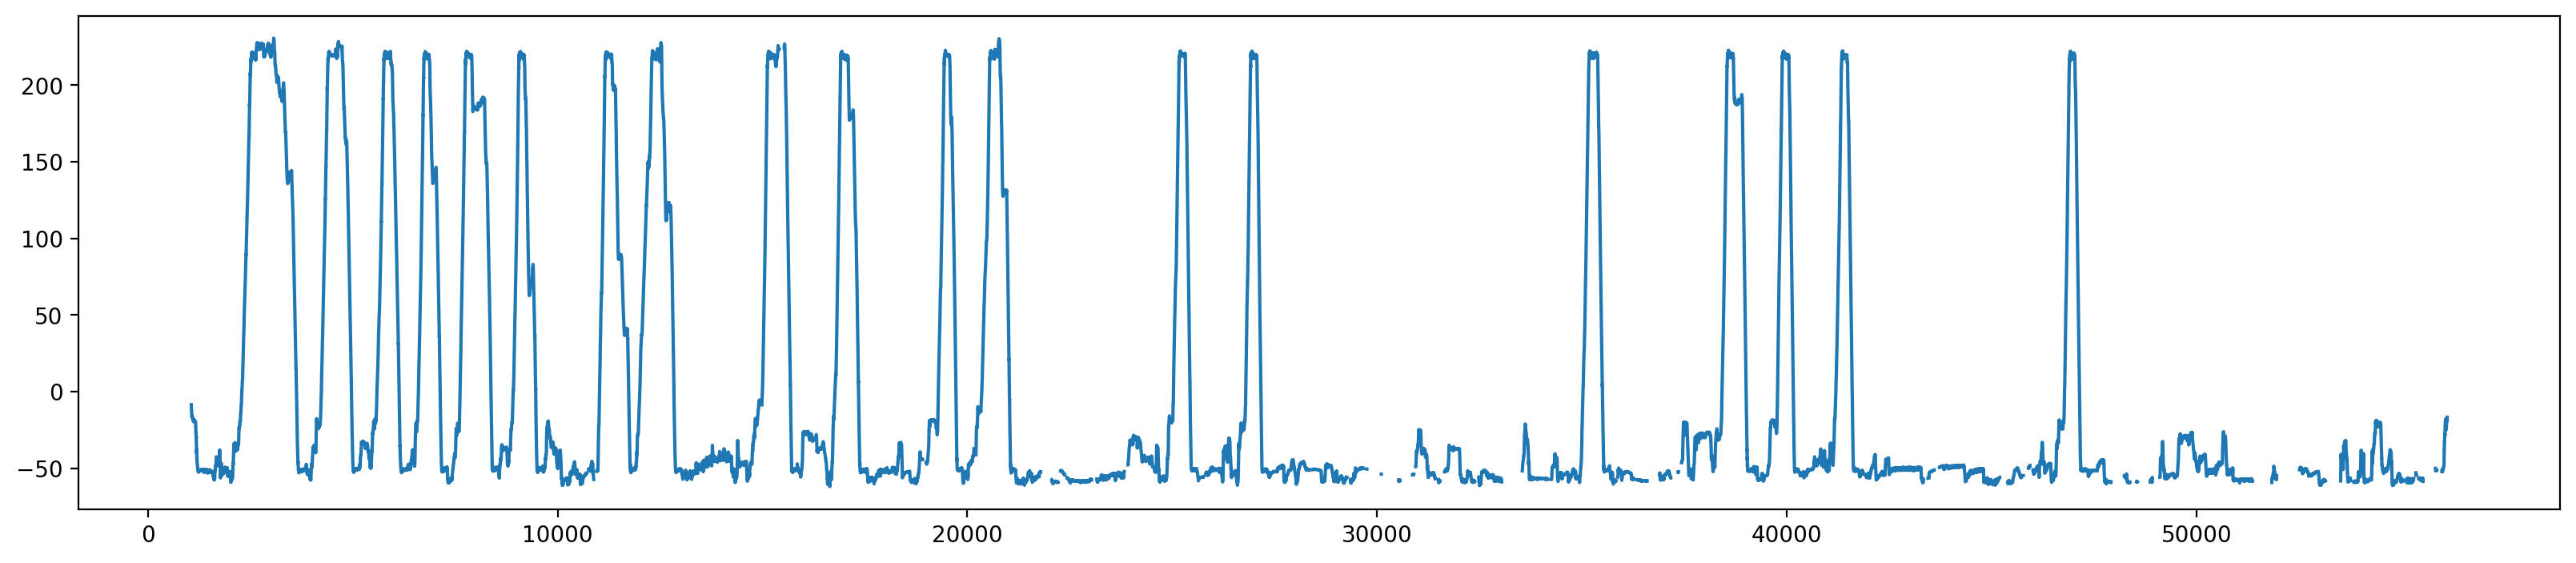

In [11]:
plt.figure(figsize=(20, 4))
plt.plot(pos.data.T)

### Section 6.2: Get outbound and inbound epochs 

In [12]:
# get outbound and inbound epochs
(outbound_epochs, inbound_epochs) = get_linear_track_lap_epochs(
    pos.abscissa_vals, pos.data[0], newLapThreshold=20
)


outbound_epochs, inbound_epochs

(<EpochArray at 0x1cf71dfa1d0: 19 epochs> of length 9:45:574 minutes,
 <EpochArray at 0x1cf6fcbf490: 20 epochs> of length 13:36:844 minutes)

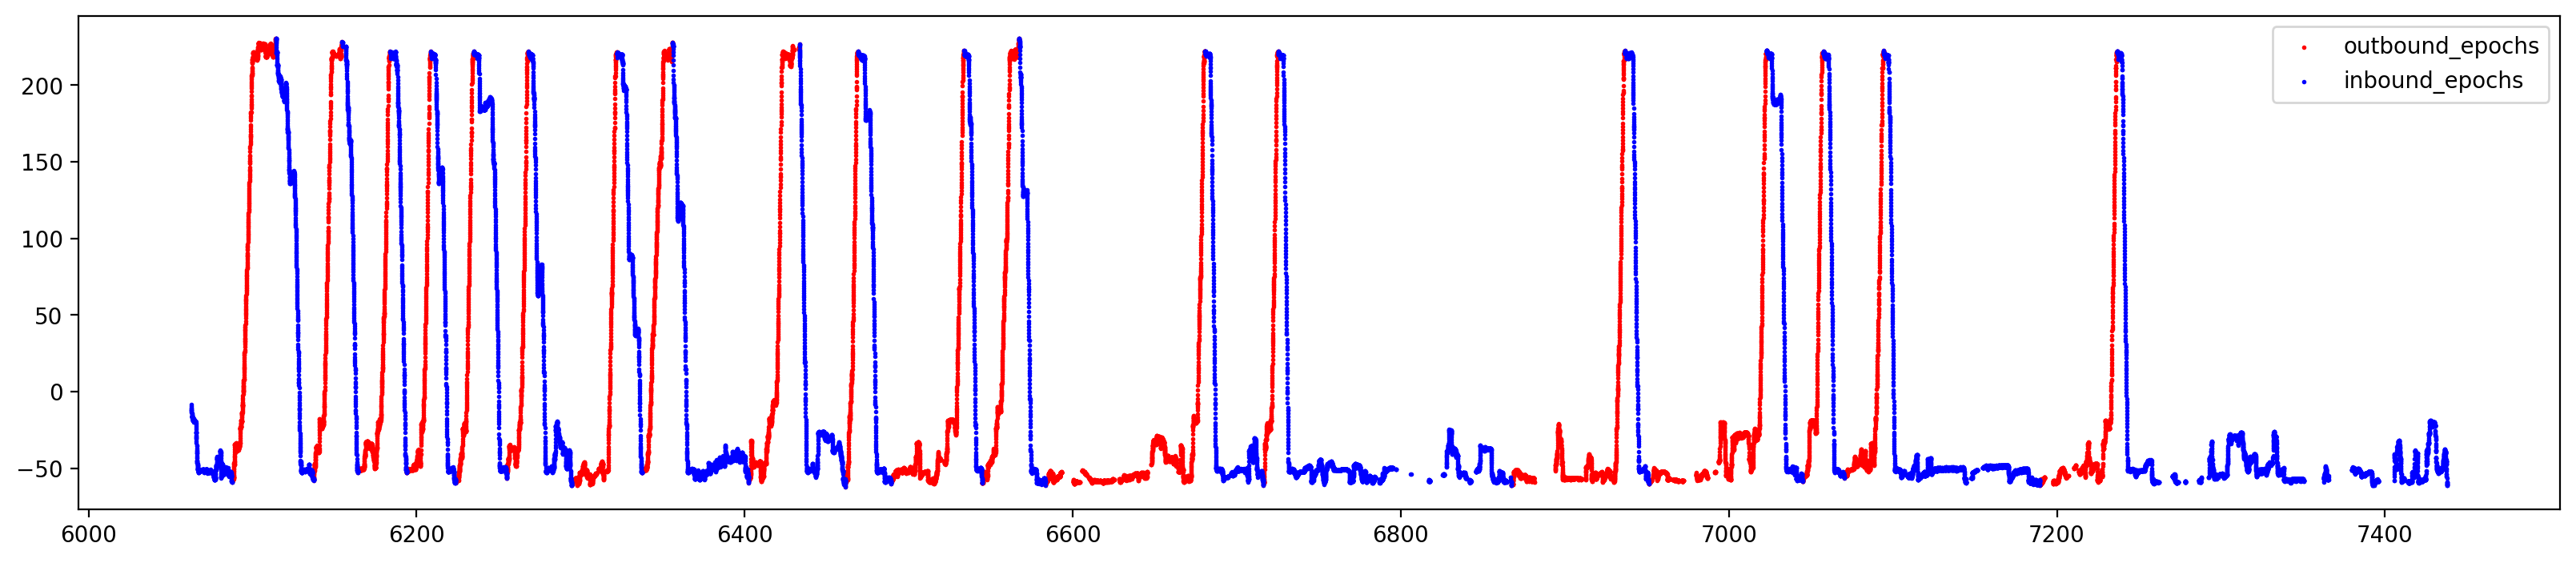

In [13]:
plt.figure(figsize=(20, 4))
plt.scatter(
    pos[outbound_epochs].abscissa_vals,
    pos[outbound_epochs].data,
    color="r",
    s=1,
    label="outbound_epochs",
)
plt.scatter(
    pos[inbound_epochs].abscissa_vals,
    pos[inbound_epochs].data,
    color="b",
    s=1,
    label="inbound_epochs",
)
plt.legend()

### Section 6.3: Make tuning curves for the outbound trajectories

In [14]:
spatial_maps = maps.SpatialMap(
    pos[outbound_epochs],
    st[outbound_epochs],
    place_field_min_size=5,
    tuning_curve_sigma=4,
    place_field_sigma=0.1,
)
spatial_maps.find_fields()

### Section 6.4: Visualize the tuning curves

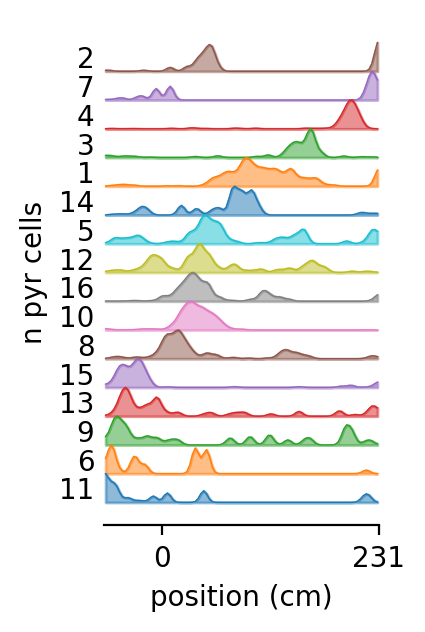

In [15]:
tc = spatial_maps.tc

w, h = set_size("thesis", fraction=0.3, subplots=(3, 1))

with npl.FigureManager(show=True, figsize=(w, h)) as (fig_, ax):
    npl.utils.skip_if_no_output(fig_)
    ax1 = npl.plot_tuning_curves1D(
        tc.reorder_units(), normalize=True, pad=1, fill=True, alpha=0.5
    )

    leg_lines = ax1.get_lines()
    plt.setp(leg_lines, linewidth=0.5)
    ax.set_xlabel("position (cm)")
    ax.set_ylabel("n pyr cells")
    ax.set_xticks([0, tc.bins.max()])

### Section 6.5: Inspect the field detection

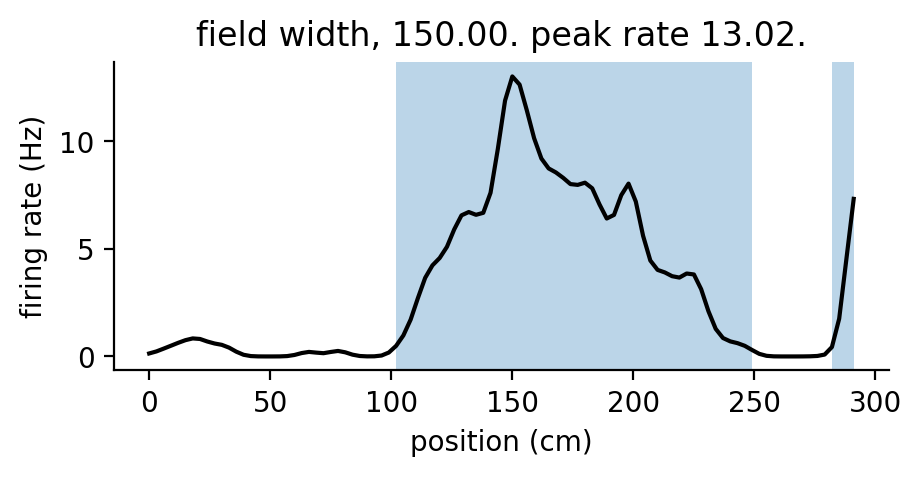

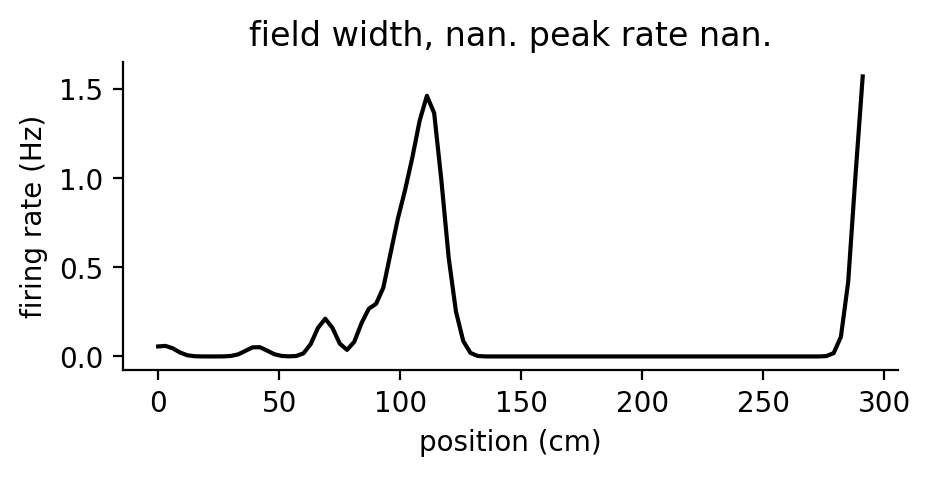

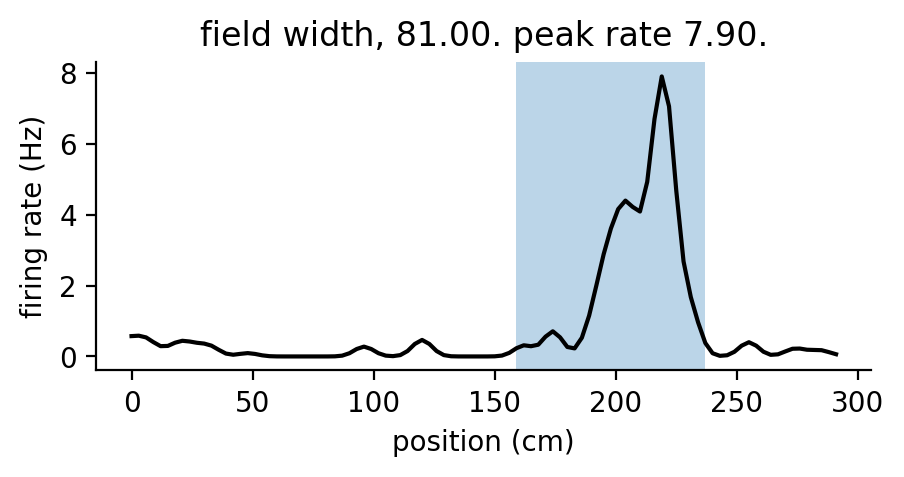

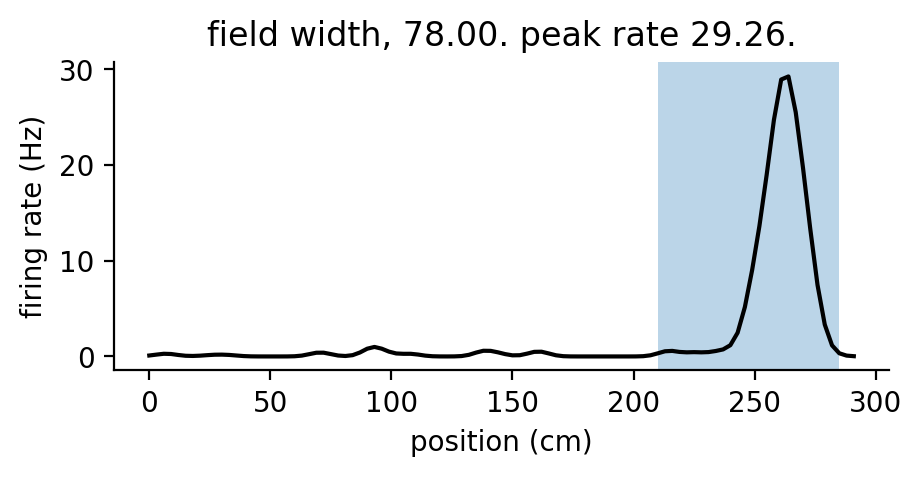

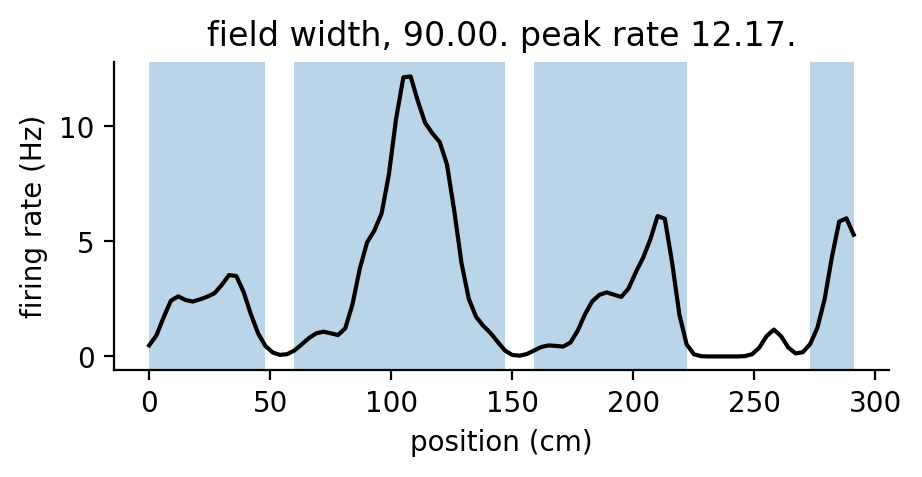

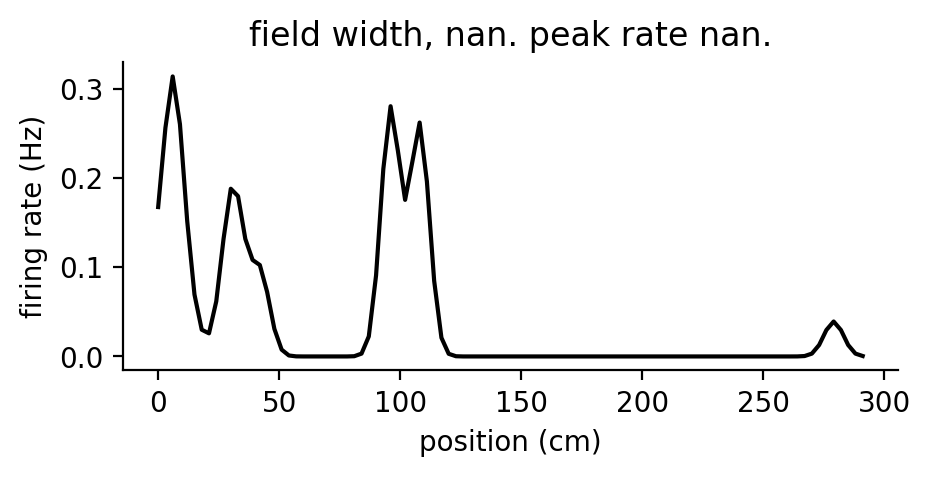

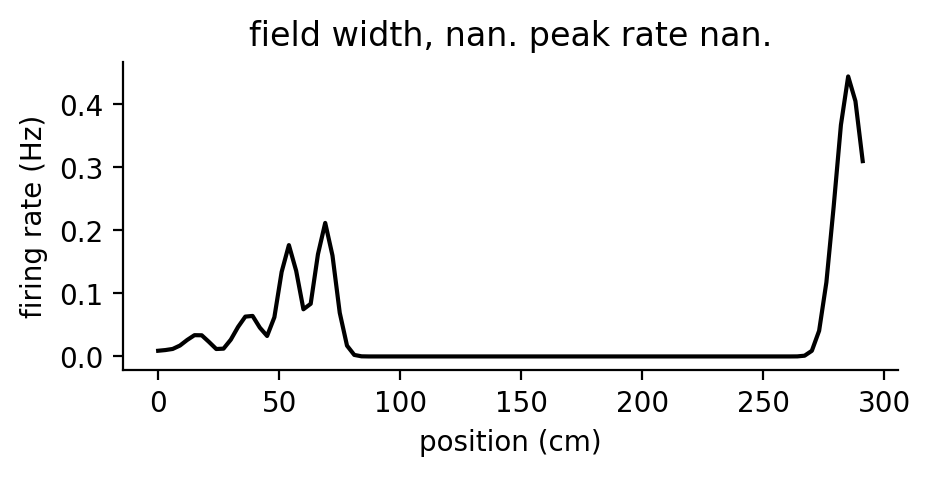

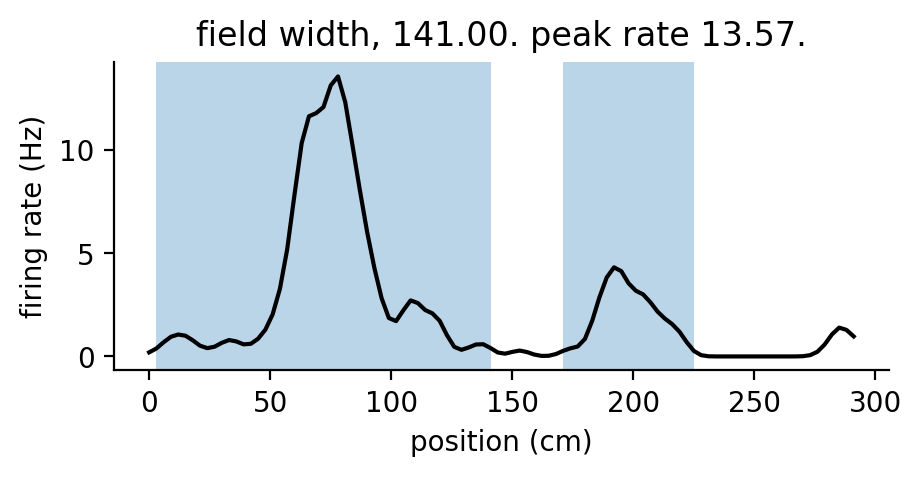

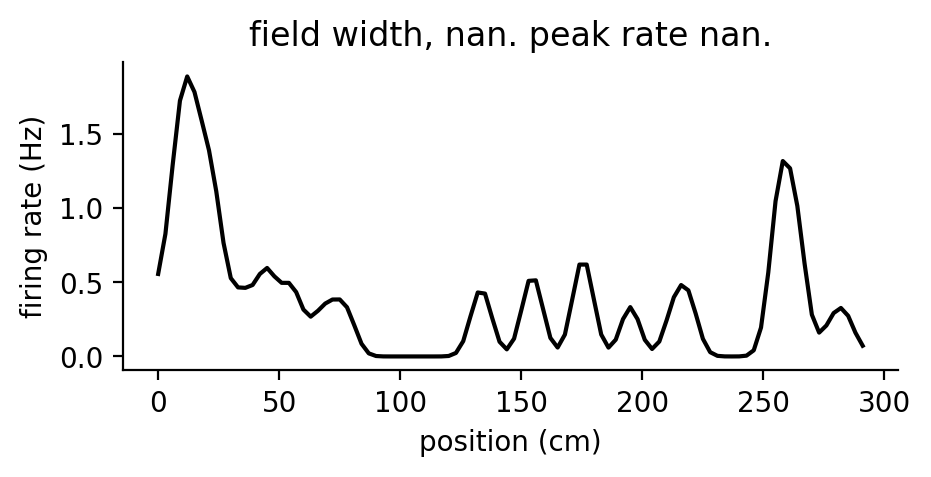

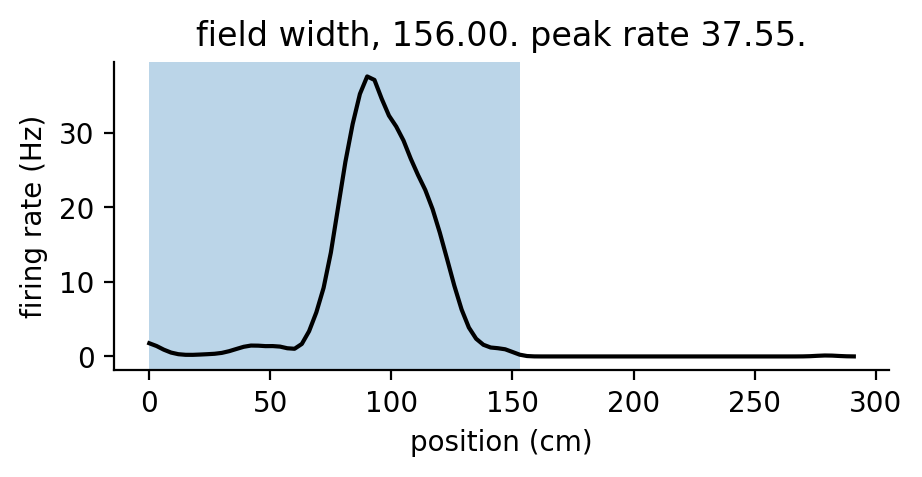

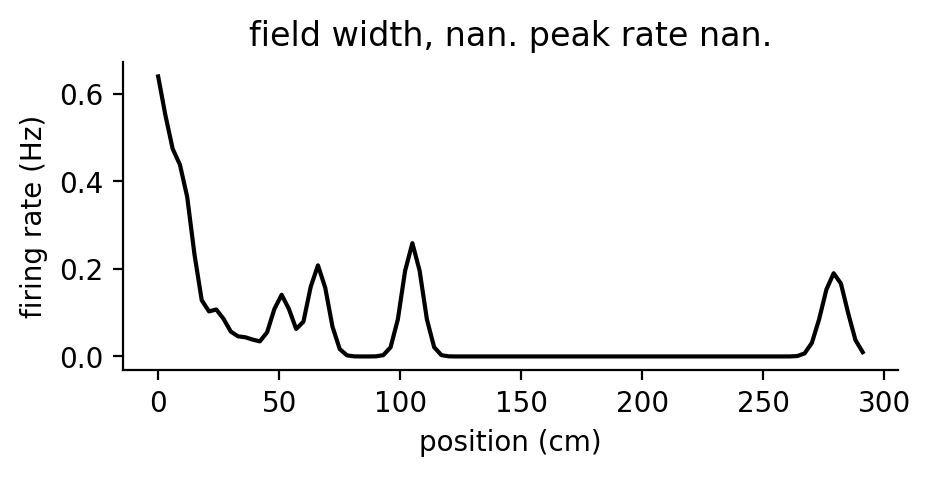

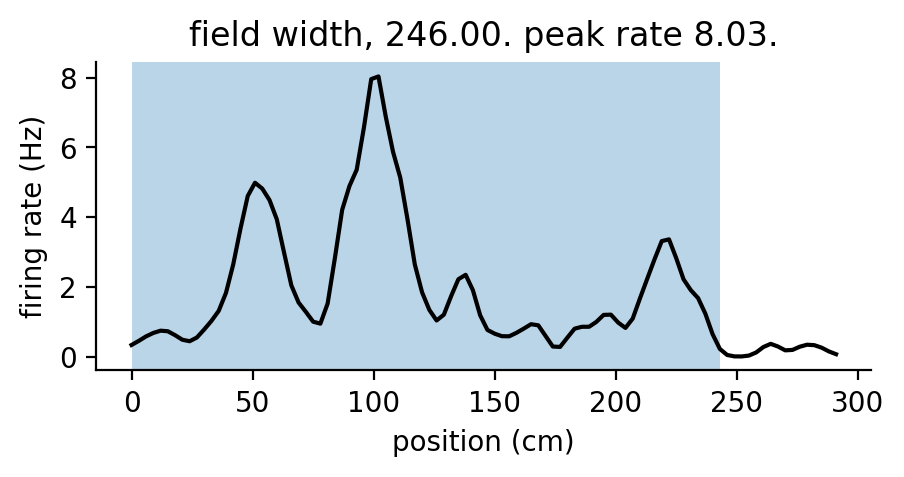

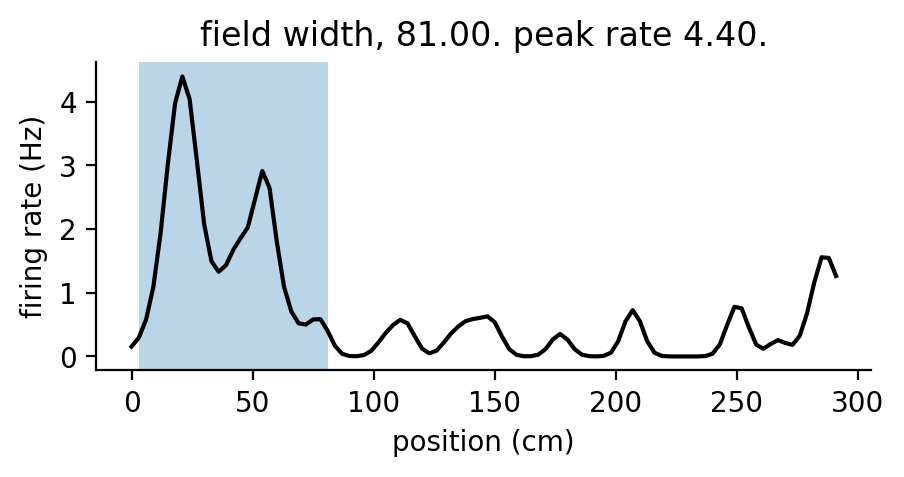

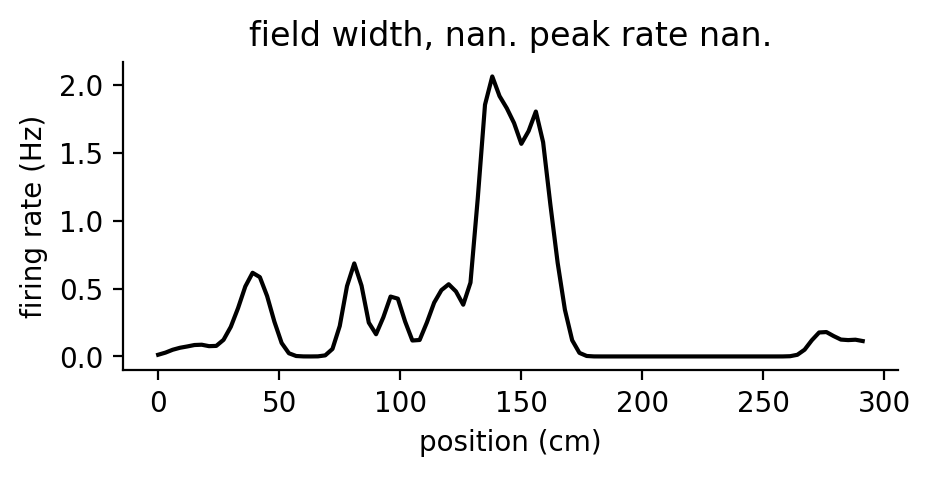

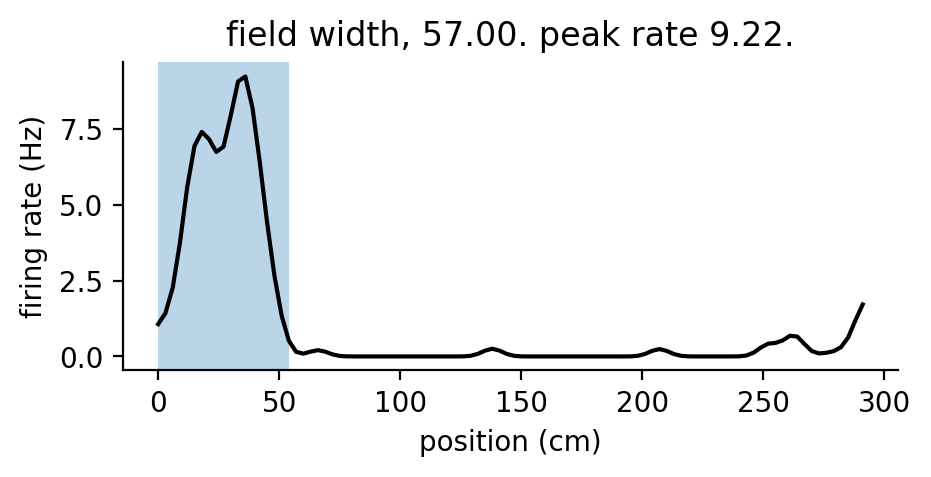

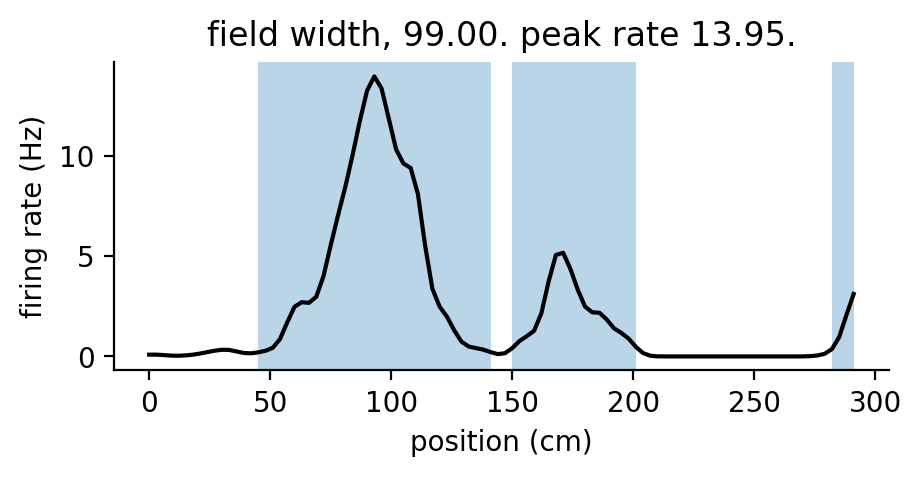

In [16]:
for ratemap_i, ratemap__ in enumerate(spatial_maps.tc.ratemap):
    ratemap_ = ratemap__.copy()
    x = np.arange(len(ratemap_)) * spatial_maps.s_binsize
    plt.figure(figsize=(5, 2))
    plt.plot(x, ratemap_, color="k")
    # field_ids = np.unique(spatial_maps.tc.field_mask[ratemap_i])
    # plt.plot(x, spatial_maps.tc.field_mask[ratemap_i], color="r")
    for interval in x[
        npy.process.find_interval(spatial_maps.tc.field_mask[ratemap_i] != 0)
    ]:
        plt.axvspan(interval[0], interval[1], alpha=0.3)
    plt.title(
        f"field width, {spatial_maps.tc.field_width[ratemap_i]:.2f}. peak rate {spatial_maps.tc.field_peak_rate[ratemap_i]:.2f}."
    )
    plt.ylabel("firing rate (Hz)")
    plt.xlabel("position (cm)")
    sns.despine()
    plt.show()

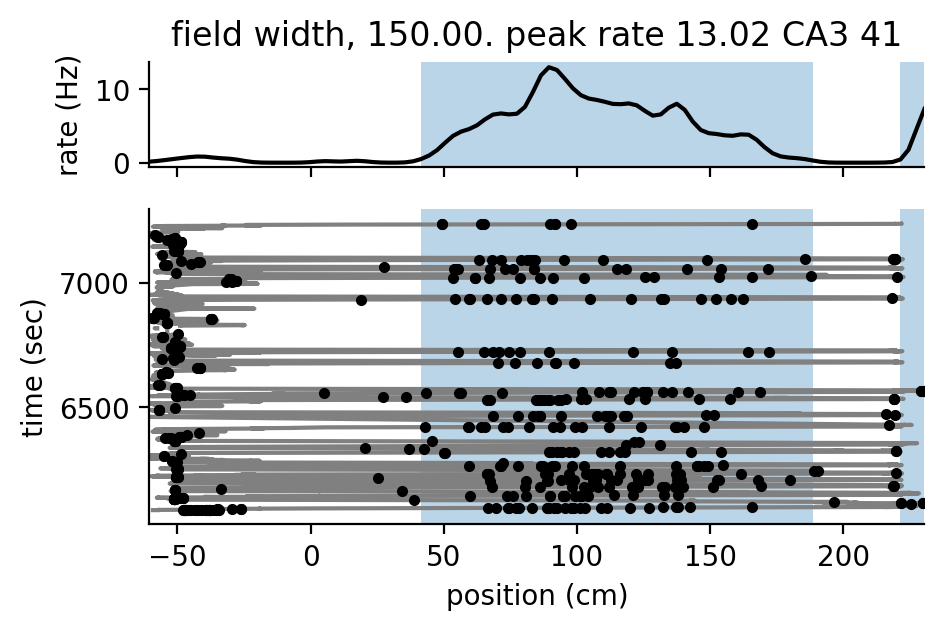

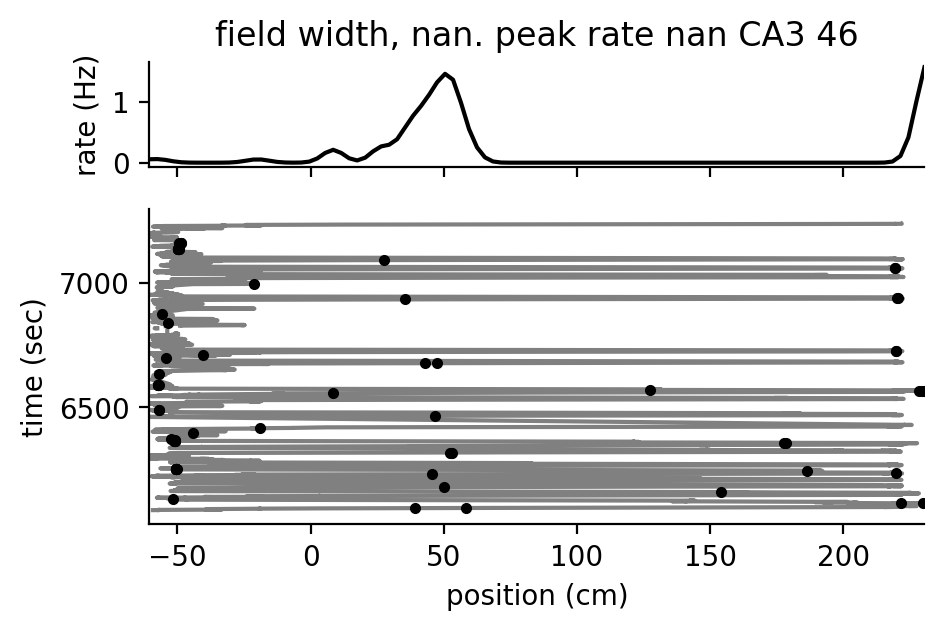

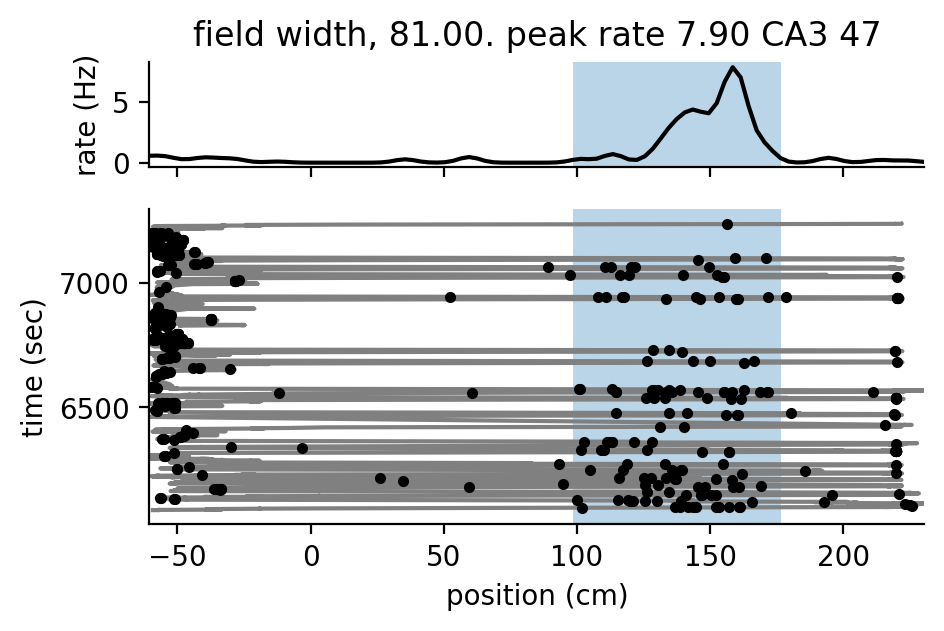

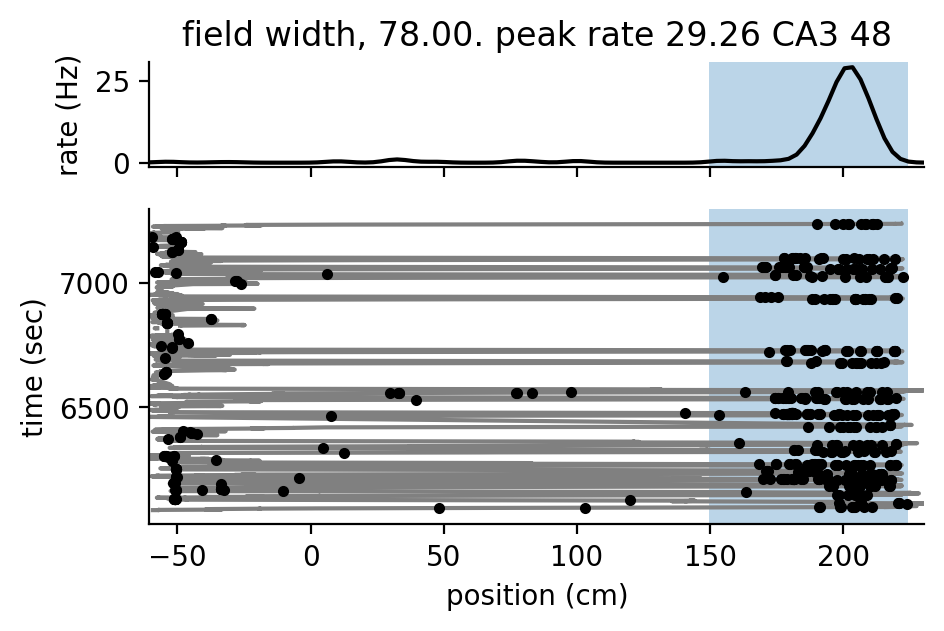

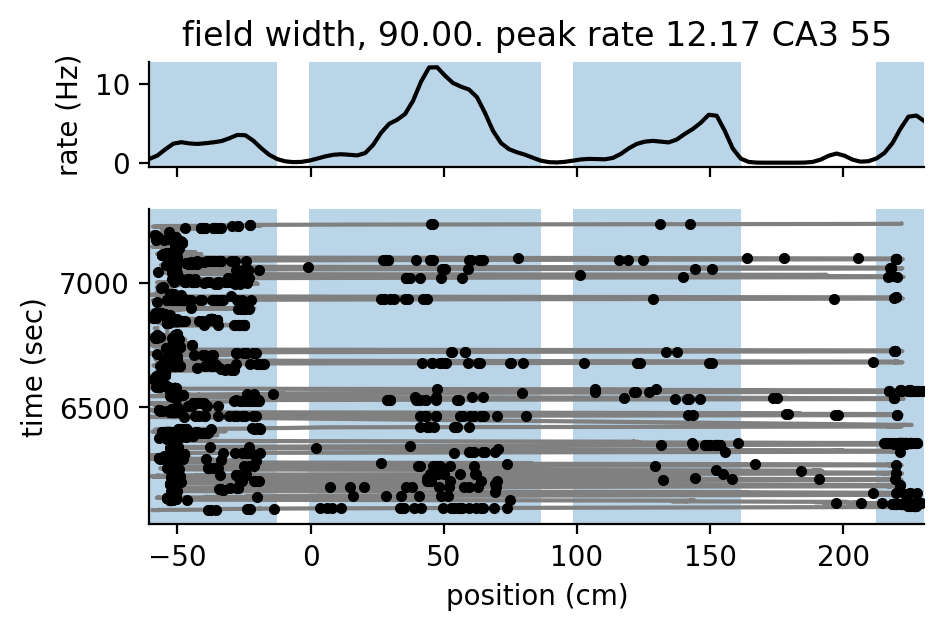

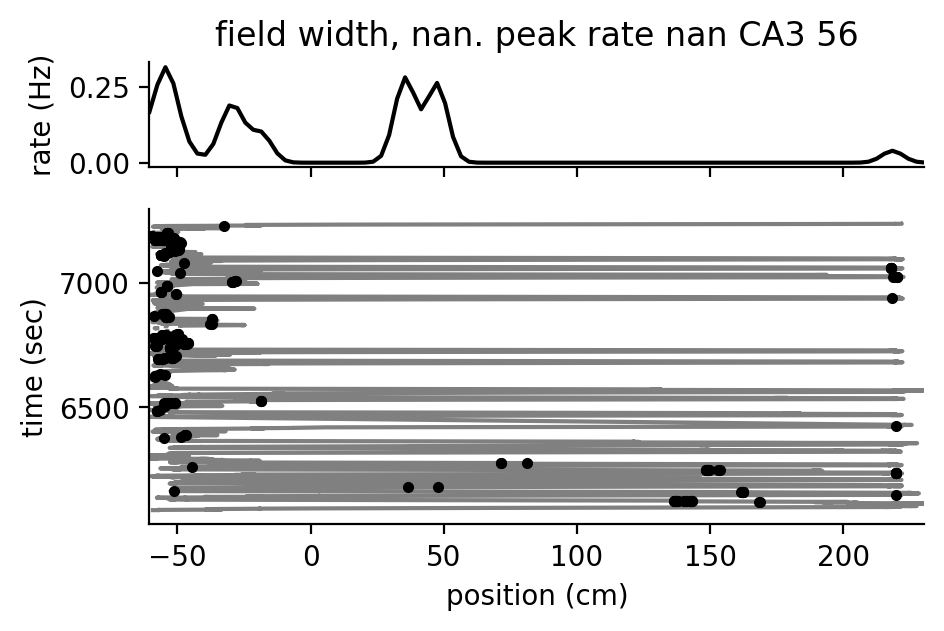

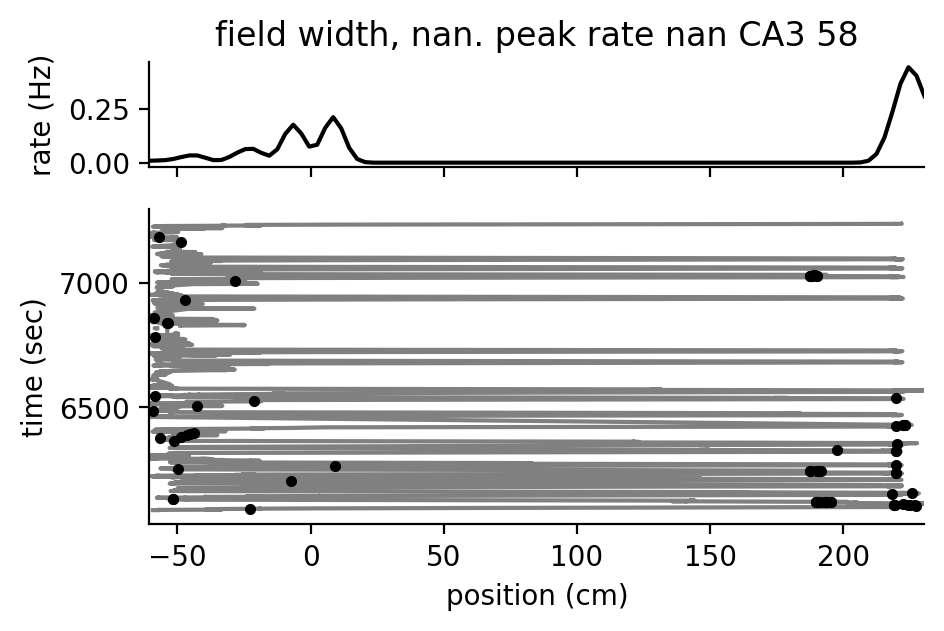

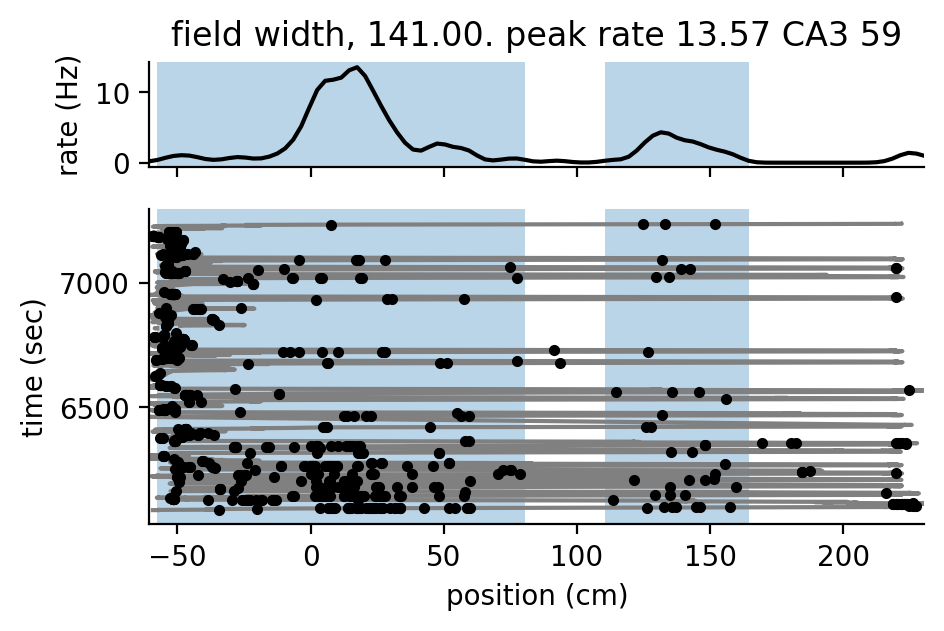

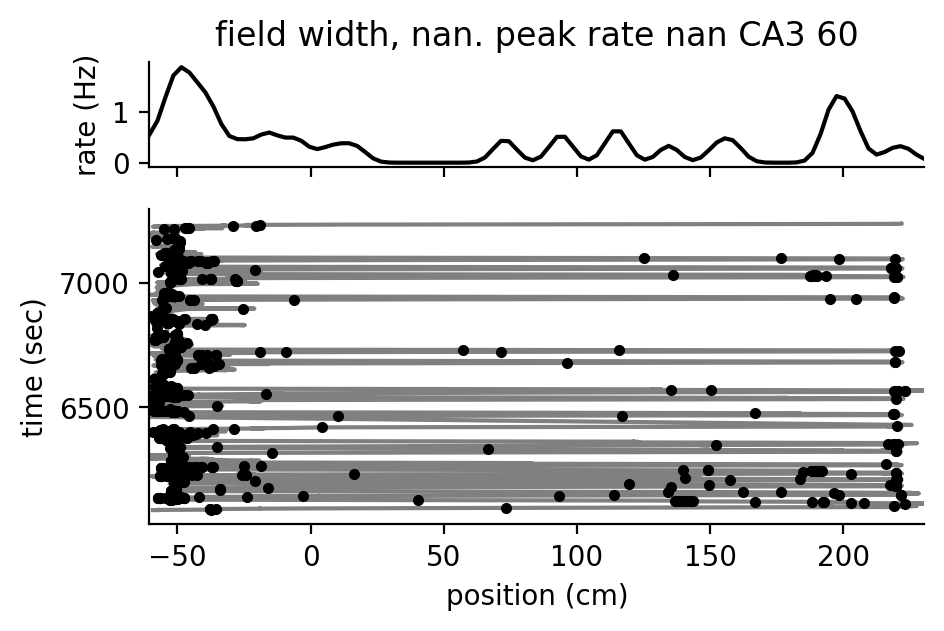

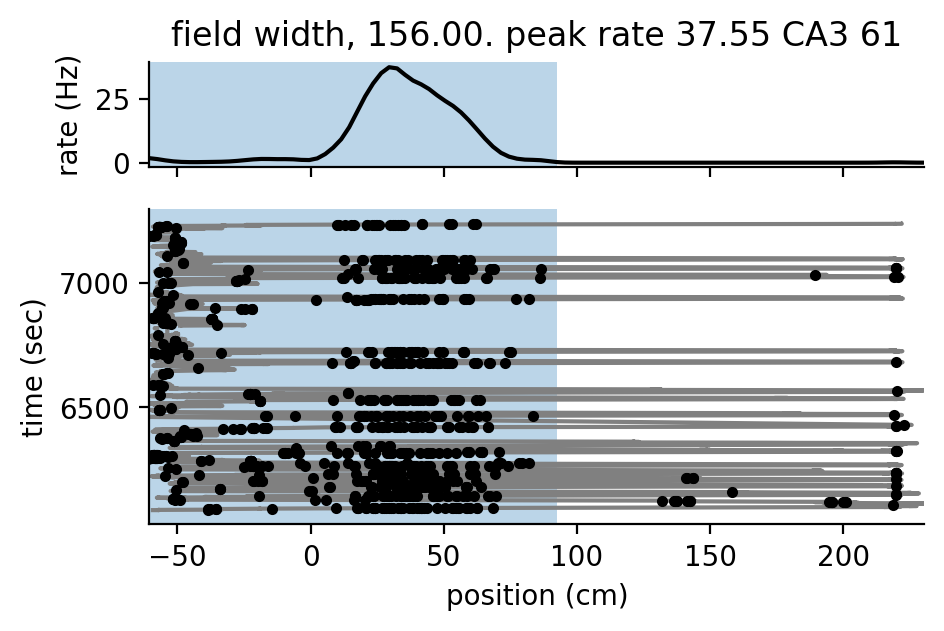

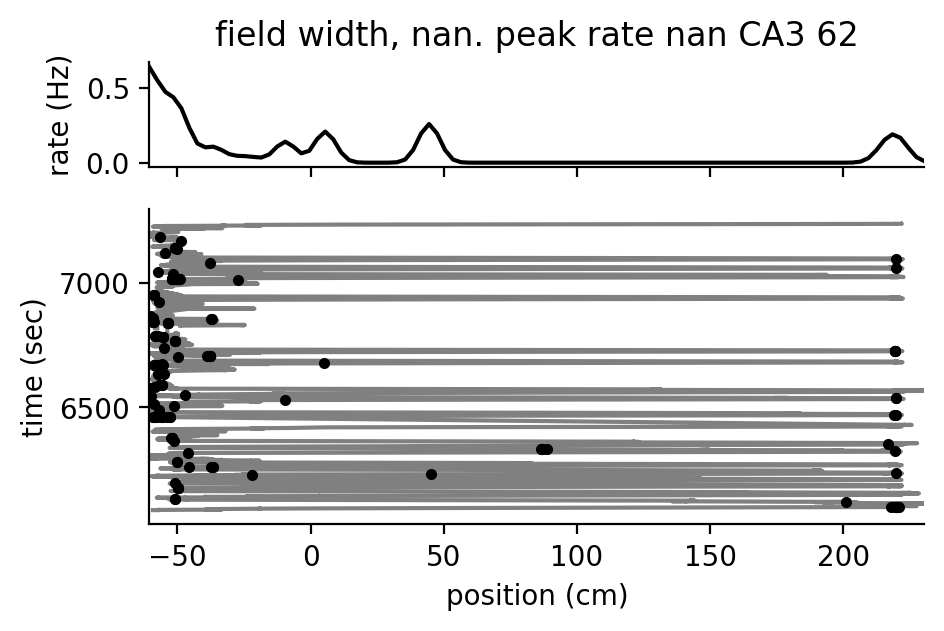

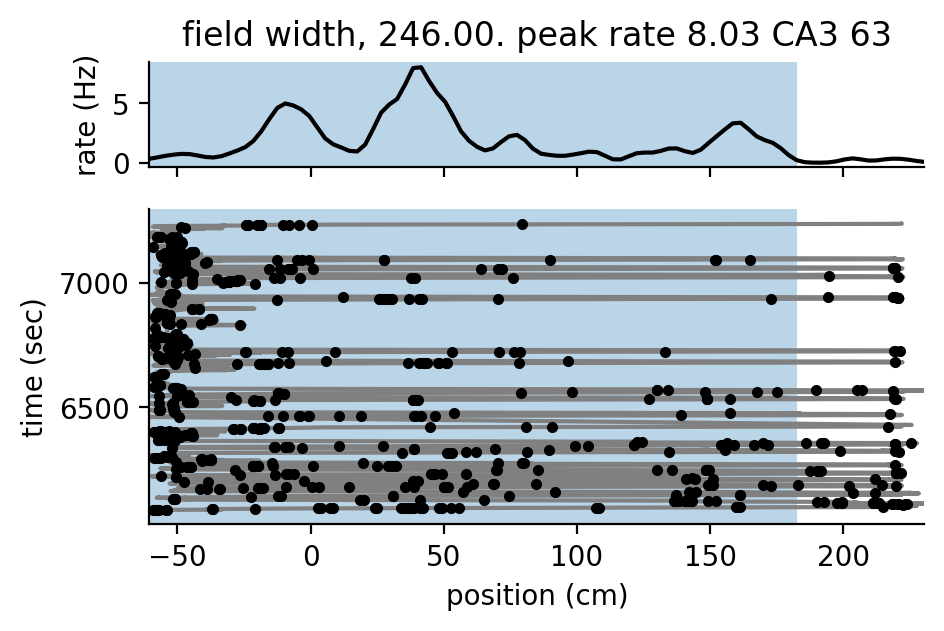

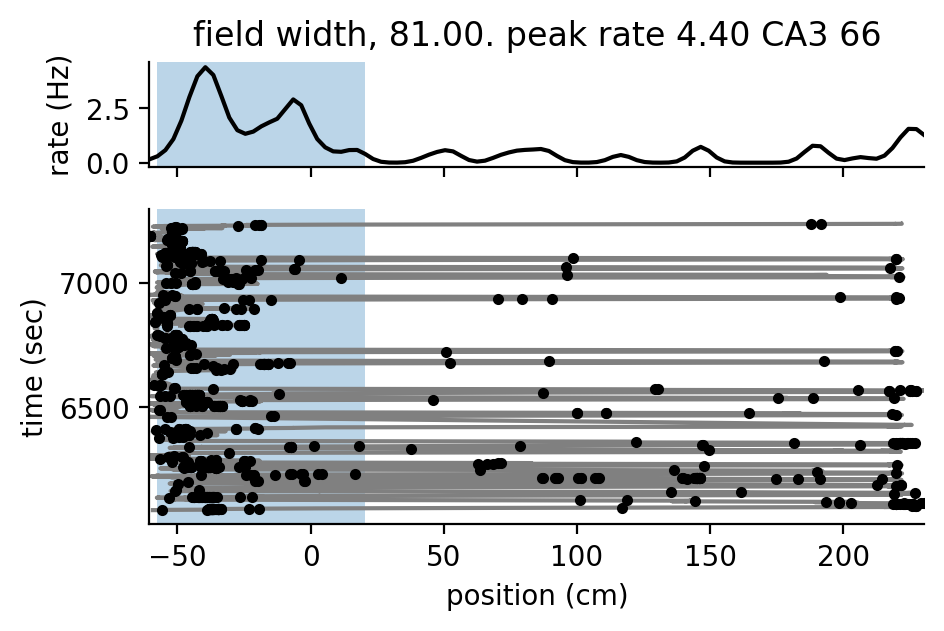

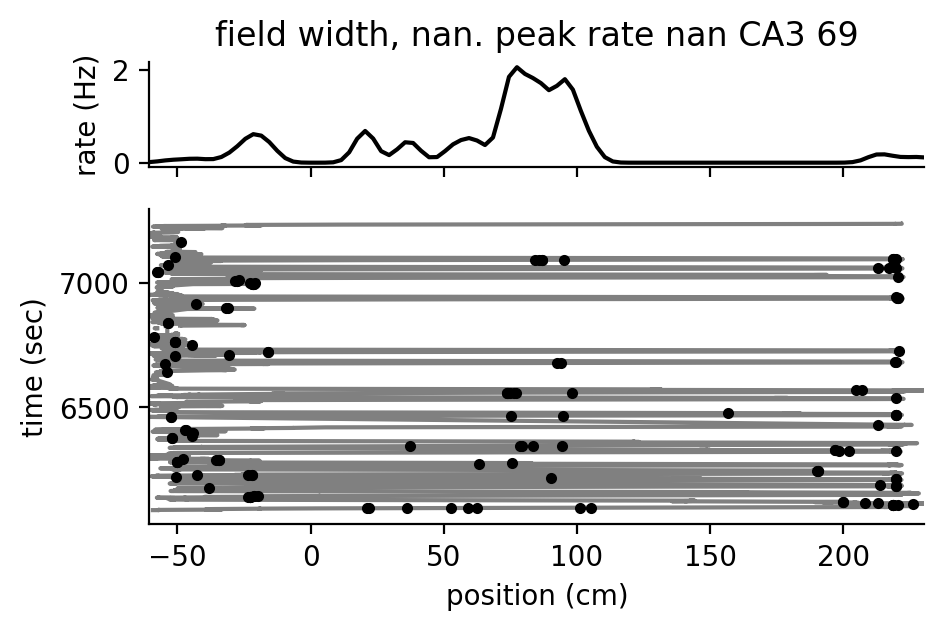

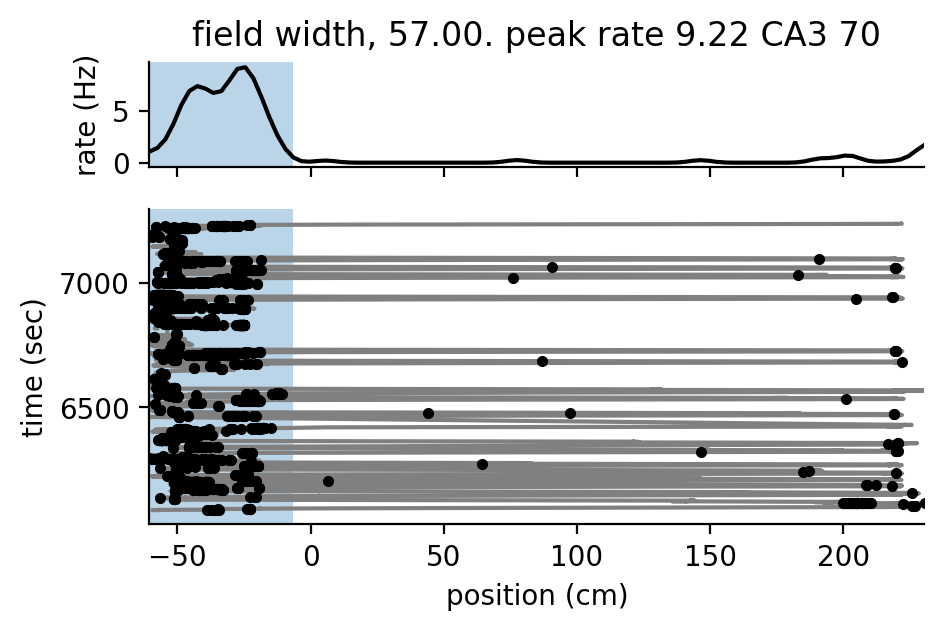

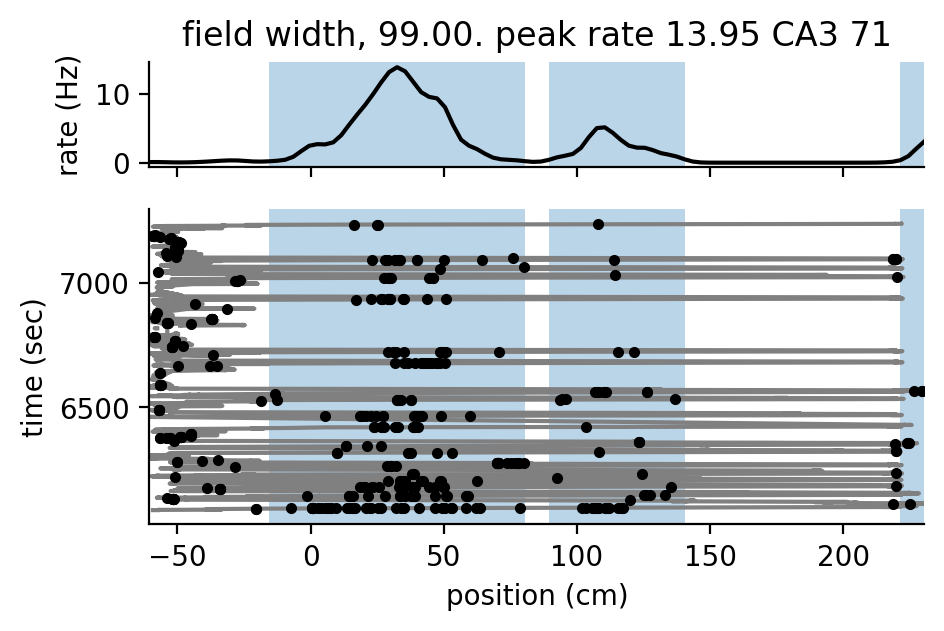

In [17]:
# pull out velocity restricted position
current_pos = pos[beh_epochs[behavior_idx]][spatial_maps.run_epochs]

# iterate over the tuning curves
for ratemap_i, ratemap__ in enumerate(spatial_maps.tc.ratemap):
    ratemap_ = ratemap__.copy()
    ratemap_[spatial_maps.tc.occupancy < 0.01] = np.nan
    fig, ax = plt.subplots(
        2, 1, figsize=(5, 3), sharex=True, gridspec_kw={"height_ratios": [1, 3]}
    )

    # plot tuning curve
    x = (spatial_maps.x_edges + np.abs(np.diff(spatial_maps.x_edges)[0] / 2))[:-1]
    ax[0].plot(x, ratemap_, color="k")

    # plot xy coords for animal position
    ax[1].plot(current_pos.data.T, current_pos.abscissa_vals, "grey")

    # plot xy coords for each spike
    x_time, pos_at_spikes = pos.asarray(
        at=st[beh_epochs[behavior_idx]][spatial_maps.run_epochs].data[ratemap_i]
    )
    ax[1].plot(pos_at_spikes.flatten(), x_time, ".", color="k")

    for interval in x[
        npy.process.find_interval(spatial_maps.tc.field_mask[ratemap_i] != 0)
    ]:
        ax[0].axvspan(interval[0], interval[1], alpha=0.3)
        ax[1].axvspan(interval[0], interval[1], alpha=0.3)

    ax[1].set_xlim(x.min(), x.max())

    # add figure labels
    ax[0].set_ylabel("rate (Hz)")
    ax[1].set_ylabel("time (sec)")
    ax[1].set_xlabel("position (cm)")

    ax[0].set_title(
        f"field width, {spatial_maps.tc.field_width[ratemap_i]:.2f}. peak rate {spatial_maps.tc.field_peak_rate[ratemap_i]:.2f} {cm.iloc[ratemap_i].brainRegion} {cm.iloc[ratemap_i].UID}"
    )
    sns.despine()
    plt.show()

## Section 7: Map continuous behavioral or neurophysiological variables

* You can map any continuous variable (speed, calcium signals, theta phase, etc.), but here we will use assembly activity

In [18]:
basepath = r"S:\data\HMC\HMC1\day8"

# load position
position_df = loading.load_animal_behavior(basepath)

# put position into a nelpy position array for ease of use
pos = nel.AnalogSignalArray(
    data=position_df["linearized"].values.T,
    timestamps=position_df.timestamps.values,
)

behavior_idx = 1

# load epoch data
epoch_df = loading.load_epoch(basepath)
beh_epochs = nel.EpochArray(np.array([epoch_df.startTime, epoch_df.stopTime]).T)

pos = pos[beh_epochs[behavior_idx]]

# get outbound and inbound epochs
outbound_epochs, inbound_epochs = get_linear_track_lap_epochs(
    pos.abscissa_vals, pos.data[0], newLapThreshold=20
)

# calculate speed
speed = nel.utils.ddt_asa(pos, smooth=True, sigma=0.250, norm=True)
run_epochs = nel.utils.get_run_epochs(speed, v1=4, v2=4).merge()


assembly_react = AssemblyReact(
    basepath=basepath,
    brainRegion="CA1",
    putativeCellType="Pyr",
    z_mat_dt=0.01,
)

# load need data (spikes, ripples, epochs)
assembly_react.load_data()

# load theta epochs
state_dict = loading.load_SleepState_states(basepath)
theta_epochs = nel.EpochArray(
    state_dict["THETA"],
)

assembly_react.get_weights(epoch=beh_epochs[behavior_idx] & theta_epochs)
assembly_react

<AssemblyReact: 75 units, 15 assemblies> of length 6:36:57:689 hours

### Section 7.1: Visualize assembly weights

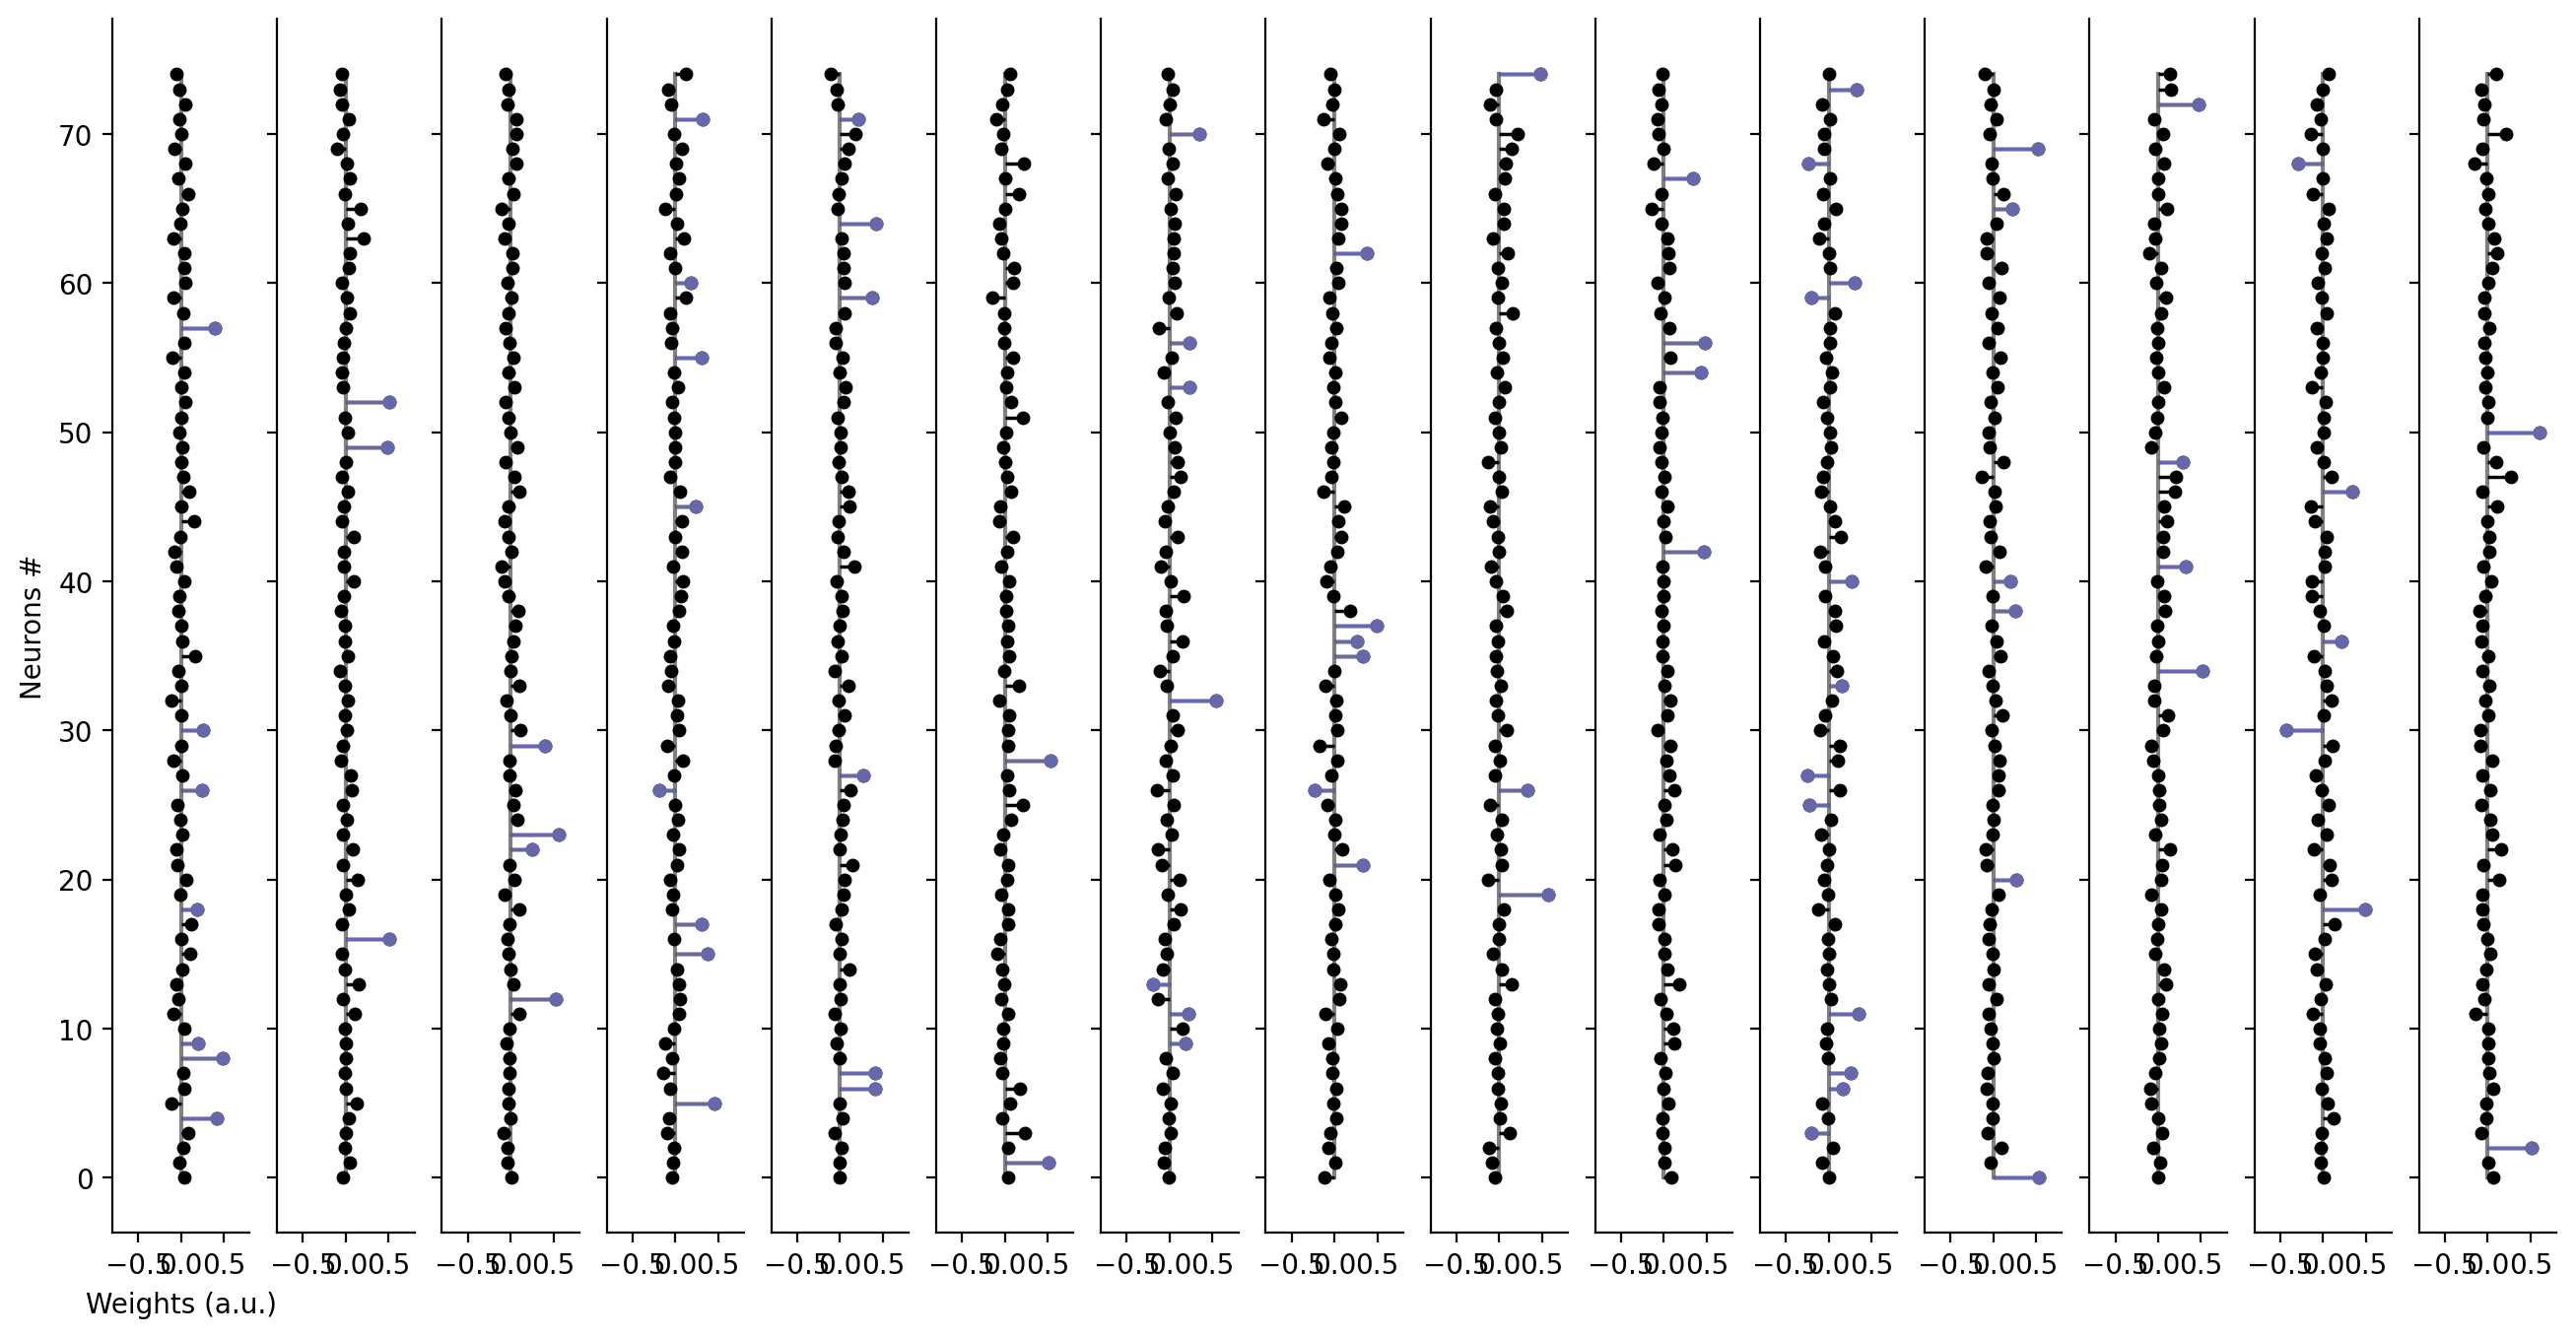

In [19]:
assembly_react.plot()
plt.show()

### Section 7.2: Compute time-resolved activations for each assembly

These are continous signals that we can now map using the SpatialMap class

In [20]:
assembly_act = assembly_react.get_assembly_act(epoch=beh_epochs[behavior_idx])
assembly_act

<AnalogSignalArray at 0x1cf72eb6a10: 15 signals> for a total of 36:48:240 minutes

### Section 7.3: Calculate spatial maps for each assembly for both directions

In [21]:
spatial_map_outbound_assembly = maps.SpatialMap(
    pos[outbound_epochs],
    assembly_act[outbound_epochs],
    speed=speed,
    tuning_curve_sigma=6,
    min_duration=0,
)

spatial_map_inbound_assembly = maps.SpatialMap(
    pos[inbound_epochs],
    assembly_act[inbound_epochs],
    speed=speed,
    tuning_curve_sigma=6,
    min_duration=0,
)

### Section 7.4: Visualize spatial maps for each assembly

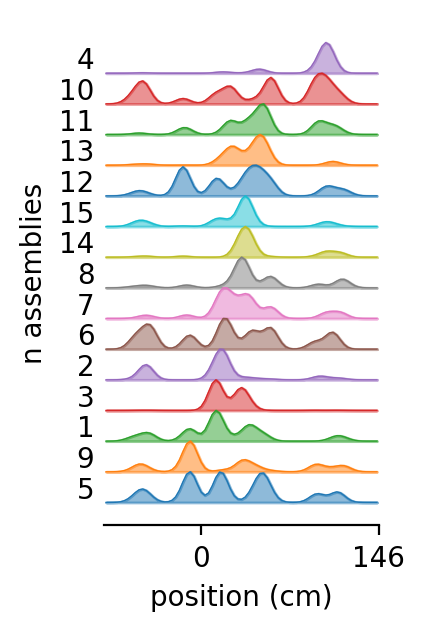

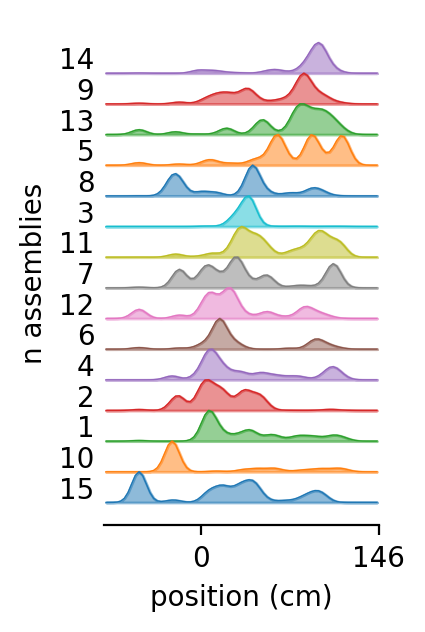

In [22]:
for tc in [spatial_map_outbound_assembly.tc, spatial_map_inbound_assembly.tc]:
    w, h = set_size("thesis", fraction=0.3, subplots=(3, 1))

    with npl.FigureManager(show=True, figsize=(w, h)) as (fig_, ax):
        npl.utils.skip_if_no_output(fig_)
        ax1 = npl.plot_tuning_curves1D(
            tc.reorder_units(), normalize=True, pad=1, fill=True, alpha=0.5
        )

        leg_lines = ax1.get_lines()
        plt.setp(leg_lines, linewidth=0.5)
        ax.set_xlabel("position (cm)")
        ax.set_ylabel("n assemblies")
        ax.set_xticks([0, tc.bins.max()])

## Section 8: Map n-dimensional behavioral variables

* You can also map n-dimensional variables, such as position, travel direction, and trial number together

Lets load data from Kenji again

In [23]:
basepath = r"Z:\Data\Kenji\ec013.961_974"

# load position
position_df = loading.load_animal_behavior(basepath)

# put position into a nelpy position array for ease of use
pos = nel.AnalogSignalArray(
    data=position_df[["x", "y"]].values.T,
    timestamps=position_df.timestamps.values,
)
# calculate speed
speed = nel.utils.ddt_asa(pos, smooth=True, sigma=0.250, norm=True)

# load in spike data from hpc pyramidal cells
st, cm = loading.load_spikes(
    basepath, putativeCellType="Pyr", brainRegion="CA1|CA2|CA3"
)

epoch_df = loading.load_epoch(basepath)
beh_epochs = nel.EpochArray(np.array([epoch_df.startTime, epoch_df.stopTime]).T)

# you can change this based on which session you want to look at
behavior_idx = 4

pos = nel.AnalogSignalArray(
    data=position_df["linearized"].values.T,
    timestamps=position_df.timestamps.values,
)
pos = pos[beh_epochs[behavior_idx]]
speed = nel.utils.ddt_asa(pos, smooth=True, sigma=0.250, norm=True)

# get outbound and inbound epochs
(outbound_epochs, inbound_epochs) = get_linear_track_lap_epochs(
    pos.abscissa_vals, pos.data[0], newLapThreshold=20
)


outbound_epochs, inbound_epochs

(<EpochArray at 0x1cf61ff2ad0: 19 epochs> of length 9:45:574 minutes,
 <EpochArray at 0x1cf61ff0cd0: 20 epochs> of length 13:36:844 minutes)

### Section 8.1: Prepare the n-dimensional position data



In [24]:
# find which position values are in outbound and inbound epochs
outbound_idx, outbound_ind = npy.process.in_intervals(
    pos.abscissa_vals, outbound_epochs.data, return_interval=True
)
inbound_idx, inbound_ind = npy.process.in_intervals(
    pos.abscissa_vals, inbound_epochs.data, return_interval=True
)

# outbound is 1 and 2 for inbound epochs
travel_direction = np.zeros_like(pos.data[0])
travel_direction[outbound_idx] = 1
travel_direction[inbound_idx] = 2

# create a trial number array
trial_number = np.zeros_like(pos.data[0])
trial_number[outbound_idx] = outbound_ind[outbound_idx]
trial_number[inbound_idx] = inbound_ind[inbound_idx]


# create a 2D array with position, travel direction, and trial number
X = np.vstack([pos.data, travel_direction, trial_number])
# remove NaN values from x coordinates
remove_idx = np.isnan(X[0, :])
X = X[:, ~remove_idx]

pos_and_trials = nel.AnalogSignalArray(data=X, time=pos.abscissa_vals[~remove_idx])
pos_and_trials

<AnalogSignalArray at 0x1cf6385bcd0: 3 signals (55 segments)> for a total of 20:04:480 minutes

### Section 8.2: Create the SpatialMap object

In [25]:
# 3 cm for position, 1 for travel direction, 1 for trial number
s_binsize = [3, 1, 1]

# ranges for each dimension, position, travel direction, trial number (with some padding)
dim_minmax = [
    [pos_and_trials[:, 0].min(), pos_and_trials[:, 0].max()],
    [0.5, 2.5],
    [
        np.nanmin(pos_and_trials[:, 2].data) - 0.5,
        np.nanmax(pos_and_trials[:, 2].data) + 0.5,
    ],
]

# Example with dimension-specific smoothing
# Different smoothing for each dimension: [position, direction, trial]
tuning_curve_sigma_array = [4, 0, 0]  # More smoothing for position, less for direction and trial

# create the spatial map
spatial_map = maps.SpatialMap(
    pos_and_trials,
    st,
    speed=speed,
    min_duration=0,
    s_binsize=s_binsize,
    dim_minmax=dim_minmax,
    tuning_curve_sigma=tuning_curve_sigma_array,
)
spatial_map

<TuningCurveND(3D) at 0x1cf6385b110> with shape (16, 98, 2, 20)

### Section 8.3: Visualize the n-dimensional spatial map

* each dimension represents a different variable, such as position, travel direction, and trial number
* we can use that to plot the ratemaps for each trial number and travel direction

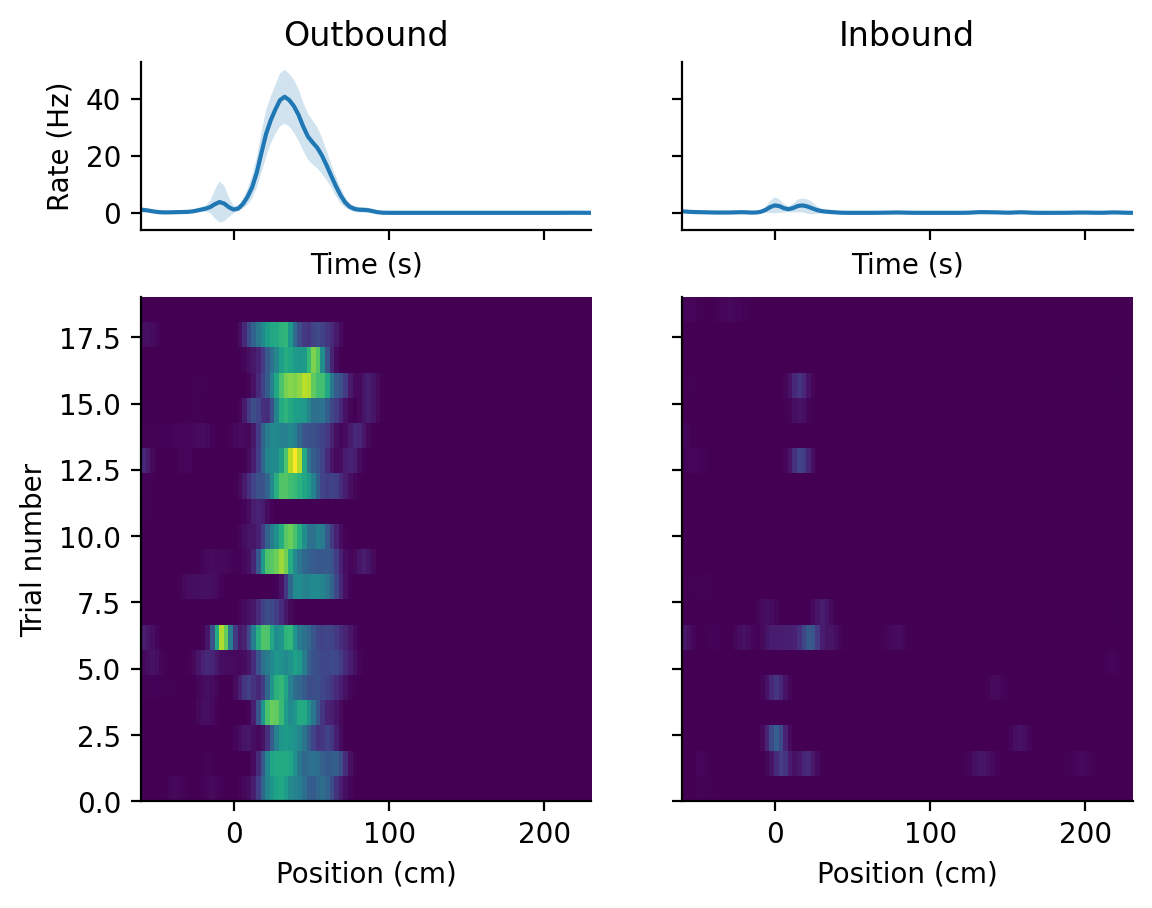

In [26]:
unit_id = 9  # choose a unit to visualize
fig, ax = plt.subplots(
    2, 2, sharey="row", sharex=True, gridspec_kw={"height_ratios": [1, 3]}
)

extent = [
    spatial_map.bin_centers[0].min(),
    spatial_map.bin_centers[0].max(),
    spatial_map.bin_centers[2].min(),
    spatial_map.bin_centers[2].max(),
]
npy.plotting.plot_peth_fast(
    spatial_map.ratemap[unit_id, :, 0, :],
    spatial_map.bin_centers[0],
    estimator=np.nanmean,
    ax=ax[0, 0],
)

ax[1, 0].imshow(
    spatial_map.ratemap[unit_id, :, 0, :].T,
    interpolation=None,
    aspect="auto",
    extent=extent,
    vmin=0,
    vmax=np.nanmax(spatial_map.ratemap[unit_id, :, :, :]),
    origin="lower",
)

npy.plotting.plot_peth_fast(
    spatial_map.ratemap[unit_id, :, 1, :],
    spatial_map.bin_centers[0],
    estimator=np.nanmean,
    ax=ax[0, 1],
)

ax[1, 1].imshow(
    spatial_map.ratemap[unit_id, :, 1, :].T,
    interpolation=None,
    aspect="auto",
    extent=extent,
    vmin=0,
    vmax=np.nanmax(spatial_map.ratemap[unit_id, :, :, :]),
    origin="lower",
)
ax[0, 0].set_title("Outbound")
ax[0, 1].set_title("Inbound")
ax[1, 0].set_ylabel("Trial number")
ax[1, 0].set_xlabel("Position (cm)")
ax[1, 1].set_xlabel("Position (cm)")
ax[0, 0].set_ylabel("Rate (Hz)")
sns.despine()

---